<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04-modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [1]:
%pip install statstests

In [2]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para StepWise
from tqdm import tqdm
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin

# Bibliotecas para Modelagem
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from scipy.stats import poisson, nbinom
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

filterwarnings('ignore')

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_parquet('/content/datasets/transactions_features.parquet')

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [5]:
df.head(10)

,date_window,frauds,total_amount,max_amount,mean_current_age,max_current_age,min_current_age,mean_per_capita_income,max_per_capita_income,min_per_capita_income,...,category_technology_telecommunications,category_arts_entertainment_recreation,category_transportation_logistics,category_retail_specialty,category_travel_hospitality,category_government_utilities,category_sports_recreation,category_manufacturing_industrial,category_personal_services,previous_frauds
0,2010-01-01 00:00:00,0,33969.41,1153.61,55.446561,101,28,23849.725926,137428.0,0.0,...,0.02,0.02,0.26,0.02,0.0,0.01,0.02,0.00,0.00,0
1,2010-01-01 12:00:00,1,65777.80,1309.71,55.994382,99,28,24395.871589,163145.0,0.0,...,0.02,0.05,0.25,0.01,0.0,0.01,0.02,0.01,0.00,0
2,2010-01-02 00:00:00,0,42680.91,1411.14,55.384810,101,29,24025.687342,163145.0,0.0,...,0.03,0.01,0.23,0.03,0.0,0.02,0.01,0.00,0.01,1
3,2010-01-02 12:00:00,0,57508.91,837.29,55.169245,99,28,23624.148317,163145.0,0.0,...,0.03,0.05,0.23,0.01,0.0,0.03,0.01,0.01,0.01,0
4,2010-01-03 00:00:00,0,40753.17,748.26,54.342708,101,28,23712.833333,91180.0,0.0,...,0.03,0.01,0.24,0.04,0.0,0.03,0.00,0.00,0.01,0
5,2010-01-03 12:00:00,1,61402.74,1412.64,54.851399,99,28,23604.919580,137428.0,0.0,...,0.02,0.02,0.23,0.02,0.0,0.03,0.00,0.01,0.02,0
6,2010-01-04 00:00:00,0,41337.34,703.85,55.037681,99,28,23354.810628,95039.0,0.0,...,0.04,0.00,0.24,0.04,0.0,0.03,0.00,0.00,0.01,1
7,2010-01-04 12:00:00,2,59630.34,1370.45,54.536178,98,28,23304.506494,163145.0,0.0,...,0.02,0.02,0.25,0.03,0.0,0.03,0.00,0.01,0.02,0
8,2010-01-05 00:00:00,1,48005.36,1812.76,54.958794,101,28,23597.177889,137428.0,0.0,...,0.03,0.00,0.23,0.05,0.0,0.02,0.00,0.01,0.01,1
9,2010-01-05 12:00:00,0,63487.16,972.19,55.522271,99,28,24139.471616,163145.0,0.0,...,0.03,0.01,0.24,0.02,0.0,0.03,0.00,0.01,0.01,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7182 entries, 0 to 7181
Data columns (total 49 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date_window                              7182 non-null   datetime64[ns]
 1   frauds                                   7182 non-null   int32         
 2   total_amount                             7182 non-null   float64       
 3   max_amount                               7182 non-null   float64       
 4   mean_current_age                         7182 non-null   float64       
 5   max_current_age                          7182 non-null   int64         
 6   min_current_age                          7182 non-null   int64         
 7   mean_per_capita_income                   7182 non-null   float64       
 8   max_per_capita_income                    7182 non-null   float64       
 9   min_per_capita_income                    

In [7]:
df.describe()

,date_window,frauds,total_amount,max_amount,mean_current_age,max_current_age,min_current_age,mean_per_capita_income,max_per_capita_income,min_per_capita_income,...,category_technology_telecommunications,category_arts_entertainment_recreation,category_transportation_logistics,category_retail_specialty,category_travel_hospitality,category_government_utilities,category_sports_recreation,category_manufacturing_industrial,category_personal_services,previous_frauds
count,7182,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,...,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000
mean,2014-12-01 05:59:59.999999744,1.788081,59624.297217,1104.515457,54.095551,100.030214,25.132971,23964.860901,141207.195906,43.212197,...,0.028648,0.016941,0.241715,0.027380,0.001422,0.026999,0.003012,0.007579,0.010858,0.365636
min,2010-01-01 00:00:00,0.000000,238.660000,136.530000,33.000000,40.000000,23.000000,18458.500000,18622.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012-06-16 15:00:00,0.000000,47364.555000,836.820000,53.686150,99.000000,24.000000,23732.069212,137428.000000,0.000000,...,0.020000,0.010000,0.230000,0.020000,0.000000,0.020000,0.000000,0.000000,0.010000,0.000000
50%,2014-12-01 06:00:00,0.000000,58146.110000,1046.855000,54.068223,101.000000,25.000000,23955.187553,163145.000000,0.000000,...,0.030000,0.010000,0.240000,0.020000,0.000000,0.030000,0.000000,0.010000,0.010000,0.000000
75%,2017-05-16 21:00:00,2.000000,71818.722500,1287.362500,54.477536,101.000000,27.000000,24191.904342,163145.000000,0.000000,...,0.030000,0.020000,0.250000,0.040000,0.000000,0.030000,0.010000,0.010000,0.010000,1.000000
max,2019-10-31 12:00:00,37.000000,90897.050000,6613.440000,62.230769,101.000000,46.000000,37597.000000,163145.000000,25565.000000,...,0.330000,0.070000,0.330000,0.070000,0.500000,0.050000,0.030000,0.500000,0.030000,1.000000
std,NaN,3.338021,13076.819254,438.799282,0.651121,1.511062,1.818150,382.371955,26799.662583,695.776223,...,0.007236,0.016096,0.018040,0.012745,0.007307,0.006178,0.004743,0.011387,0.004695,0.481642


## Implementação de Modelos

In [8]:
y = df['frauds']
X = df.drop(columns=['date_window'])

In [9]:
y.shape

(7182,)

In [10]:
y.value_counts().sort_index()

,count
frauds,
0,4556
1,549
2,381
3,289
4,259
5,223
6,193
7,173
8,116


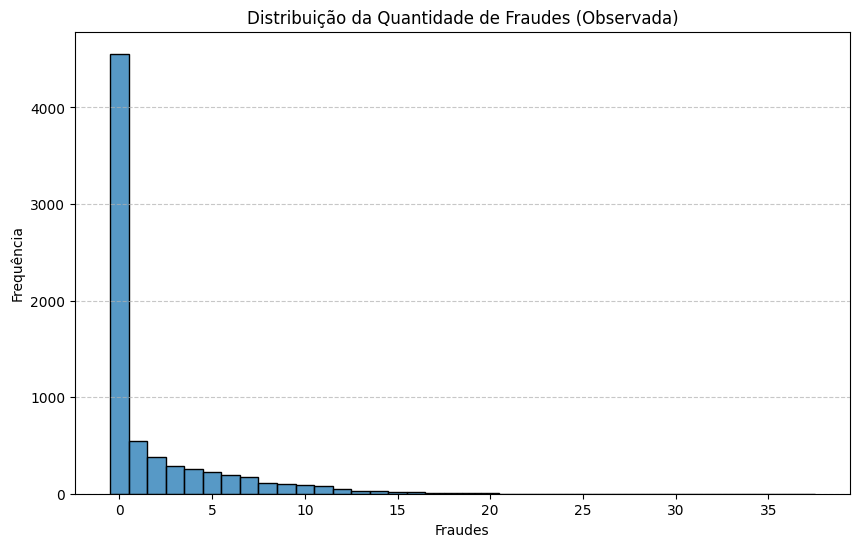

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=range(0, int(np.max(y)) + 2), stat='count', discrete=True)
plt.title('Distribuição da Quantidade de Fraudes (Observada)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, int(np.max(y)) + 1, 5)) # Ajuste os ticks para melhor visualização
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Optimization terminated successfully.
         Current function value: 1.586140
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.561458
         Iterations: 29
         Function evaluations: 33
         Gradient evaluations: 33


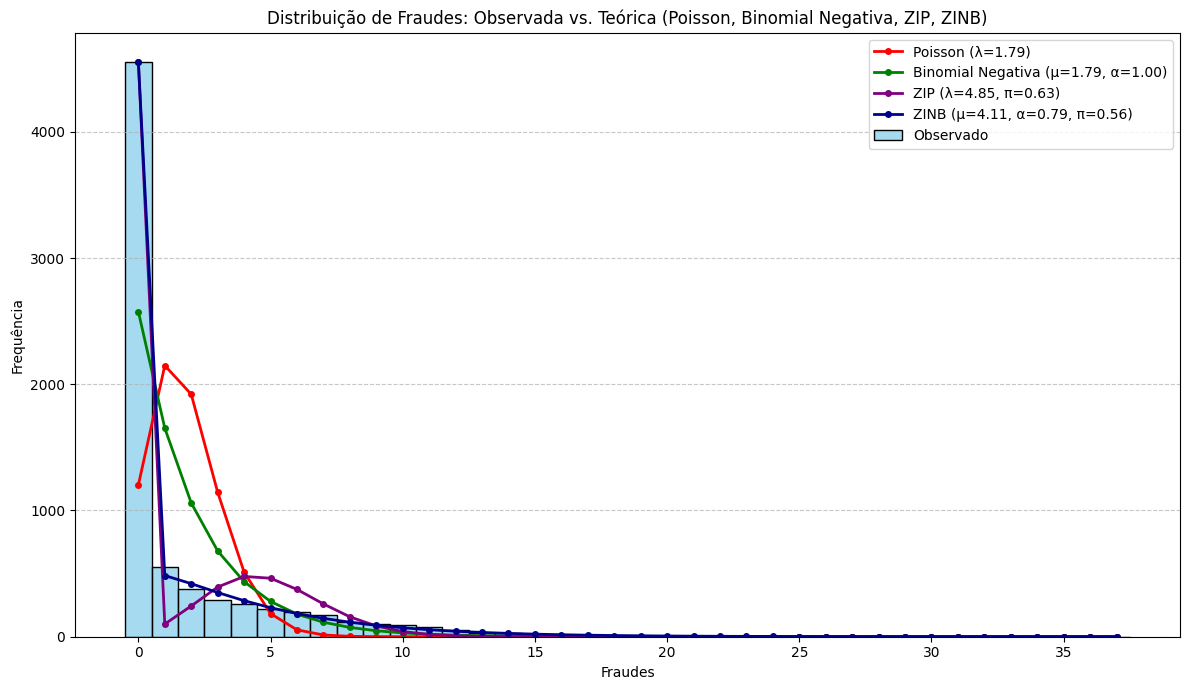

In [12]:
max_fraudes = int(np.max(y))
bins = np.arange(0, max_fraudes + 2)
df_fraudes = pd.DataFrame({'Fraudes': y})

plt.figure(figsize=(12, 7))
ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', label='Observado')

# --- Poisson ---
lambda_poisson = np.mean(y)
poisson_pmf = poisson.pmf(bins[:-1], lambda_poisson)
poisson_freq = poisson_pmf * len(y)
ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

# --- Binomial Negativa ---
exog = np.ones(len(y))
try:
    negbin_model = sm.NegativeBinomial.from_formula("Fraudes ~ 1", data=df_fraudes).fit(disp=True, maxiter=1000)
    mu_negbin = np.exp(negbin_model.params['Intercept'])
    alpha_negbin = negbin_model.scale

    n_param_scipy = 1 / alpha_negbin
    p_param_scipy = n_param_scipy / (n_param_scipy + mu_negbin)
    negbin_pmf = nbinom.pmf(bins[:-1], n=n_param_scipy, p=p_param_scipy)
    negbin_freq = negbin_pmf * len(y)
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo Binomial Negativa com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Poisson ---
try:
    zip_model = sm.ZeroInflatedPoisson.from_formula("Fraudes ~ 1", data=df_fraudes).fit(maxiter=1000, disp=False)
    lambda_zip = np.exp(zip_model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-zip_model.params['inflate_const'])) # Transformando o logit de volta para probabilidade

    zip_freq = np.zeros_like(bins[:-1], dtype=float)
    for k in bins[:-1]:
        if k == 0:
            # Probabilidade de ser 0 = (prob de ser zero extra) + (prob de ser 0 pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)) * len(df_fraudes)
        else:
            # Probabilidade de ser k > 0 = (prob de ser k pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (1 - pi_zip) * poisson.pmf(k, lambda_zip) * len(df_fraudes)
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZIP com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Binomial Negative ---
try:
    zinb_model = sm.ZeroInflatedNegativeBinomialP.from_formula(
        "Fraudes ~ 1",
        inflation_formula="~ 1",
        data=df_fraudes
    ).fit(maxiter=1000, cov_type='HC0')

    # Parâmetros da parte Negative Binomial
    mu_zinb = np.exp(zinb_model.params['Intercept']) # Média estimada (exp de intercepto)
    alpha_zinb = zinb_model.params['alpha'] # Parâmetro de dispersão (alpha)

    # Parâmetro da parte de inflação de zeros (probabilidade de ser um zero extra)
    pi_zinb_logit = zinb_model.params['inflate_const'] # Nome do parâmetro pode variar dependendo da versão
    pi_zinb = 1 / (1 + np.exp(-pi_zinb_logit)) # Transformando logit para probabilidade

    # Calcular as frequências teóricas para o ZINB
    zinb_freq = np.zeros_like(bins[:-1], dtype=float)

    n_param_scipy_zinb = 1 / alpha_zinb
    p_param_scipy_zinb = n_param_scipy_zinb / (n_param_scipy_zinb + mu_zinb)

    for k in bins[:-1]:
        if k == 0:
            zinb_freq[k] = (pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n_param_scipy_zinb, p=p_param_scipy_zinb)) * len(df_fraudes)
        else:
            zinb_freq[k] = (1 - pi_zinb) * nbinom.pmf(k, n=n_param_scipy_zinb, p=p_param_scipy_zinb) * len(df_fraudes)
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZINB: {e}")
    print("Verifique se a versão do statsmodels é recente o suficiente ou se os dados são muito extremos.")


plt.title('Distribuição de Fraudes: Observada vs. Teórica (Poisson, Binomial Negativa, ZIP, ZINB)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, max_fraudes + 1, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### Métodos Auxiliares

In [13]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [14]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

In [15]:
def overdisp_plot(model, model_type_name):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues.apply(lambda x: 0 if np.isnan(x) or int(round(x))< 0 else int(round(x)))

  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Taxa de Fraudes)")
  plt.ylabel("Resíduos de Pearson Padronizados")
  plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

In [16]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

In [17]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp
from typing import Dict, List, Tuple, Optional, Union
from tqdm.auto import tqdm

class StepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Seletor de features stepwise otimizado para modelos Zero-Inflated (ZIP/ZINB).

    Esta classe implementa um algoritmo de seleção stepwise forward/backward
    para modelos de contagem com inflação de zeros. A versão otimizada inclui
    cache, paralelização, batch processing e progress bars para melhor performance.

    Funcionalidades principais:
    - Seleção automática de features para componentes exógenos e inflacionados
    - Suporte para critérios AIC, BIC e Log-Likelihood
    - Validação de significância estatística
    - Cache inteligente para evitar recomputações
    - Processamento paralelo de features
    - Progress bars elegantes com tqdm
    - Batch processing para eficiência
    - Validação adaptativa baseada na complexidade do modelo

    Otimizações implementadas:
    1. **Cache de matrizes**: Evita recriação de matrizes de design idênticas
    2. **Cache de modelos**: Reutiliza resultados de modelos já ajustados
    3. **Validação adaptativa**: Pula validações desnecessárias em modelos simples
    4. **Early stopping**: Para validações assim que encontra problema
    5. **Paralelização**: Testa múltiplas features simultaneamente
    6. **Batch processing**: Processa features em lotes para otimização
    7. **Progress bars**: Feedback visual elegante durante o processo
    8. **Otimização de memória**: Gerenciamento eficiente de cache

    Compatível com scikit-learn pipeline através de BaseEstimator e TransformerMixin.

    Examples
    --------
    Exemplo básico com dados de contagem:

    >>> import numpy as np
    >>> import pandas as pd
    >>> from stepwise_optimized import StepwiseZeroInflated
    >>>
    >>> # Dados de exemplo
    >>> X = pd.DataFrame({
    ...     'idade': np.random.normal(35, 10, 1000),
    ...     'renda': np.random.exponential(50000, 1000),
    ...     'educacao': np.random.choice([1, 2, 3, 4], 1000),
    ...     'sexo': np.random.choice([0, 1], 1000)
    ... })
    >>> y = np.random.poisson(2, 1000)  # Variável de contagem
    >>> # Adicionar inflação de zeros
    >>> zero_mask = np.random.binomial(1, 0.3, 1000)
    >>> y = np.where(zero_mask, 0, y)
    >>>
    >>> # Configuração básica
    >>> stepwise = StepwiseZeroInflated(
    ...     alpha=0.05,
    ...     model_type='ZIP',
    ...     verbose=False  # Progress bar será mostrado
    ... )
    >>>
    >>> # Ajustar modelo
    >>> stepwise.fit(X, y)
    >>>
    >>> # Verificar features selecionadas
    >>> print("Exógenas:", stepwise.columns_exog_)
    >>> print("Inflacionadas:", stepwise.columns_inf_)

    Exemplo com configurações avançadas:

    >>> # Configuração otimizada para dataset grande
    >>> stepwise_advanced = StepwiseZeroInflated(
    ...     alpha=0.01,                 # Mais rigoroso
    ...     model_type='ZINB',          # Negative Binomial
    ...     selection_criterion='BIC',  # Penaliza mais a complexidade
    ...     max_iter=50,               # Máximo de iterações
    ...     verbose=False,             # Progress bar
    ...     use_cache=True,            # Cache habilitado
    ...     parallel_features=True,    # Paralelização
    ...     n_jobs=4,                  # 4 threads
    ...     batch_size=8               # Lotes de 8 features
    ... )
    >>>
    >>> stepwise_advanced.fit(X, y)
    >>>
    >>> # Estatísticas de cache
    >>> cache_stats = stepwise_advanced.get_cache_stats()
    >>> print(f"Cache hit rate: {cache_stats['hit_rate_percent']:.1f}%")

    Exemplo para análise de fraudes (contagem de transações suspeitas):

    >>> # Features para análise de fraude
    >>> X_fraud = pd.DataFrame({
    ...     'valor_transacao': np.random.lognormal(5, 1, 5000),
    ...     'hora_transacao': np.random.choice(range(24), 5000),
    ...     'dia_semana': np.random.choice(range(7), 5000),
    ...     'historico_cliente': np.random.exponential(100, 5000),
    ...     'num_cartoes': np.random.poisson(2, 5000),
    ...     'score_risco': np.random.beta(2, 5, 5000)
    ... })
    >>>
    >>> # Número de transações suspeitas por cliente (com zeros inflacionados)
    >>> lambda_fraud = np.exp(-2 + 0.5 * X_fraud['score_risco'])
    >>> y_fraud = np.random.poisson(lambda_fraud)
    >>> # 40% dos clientes sem nenhuma transação suspeita
    >>> zero_inflation = np.random.binomial(1, 0.4, 5000)
    >>> y_fraud = np.where(zero_inflation, 0, y_fraud)
    >>>
    >>> # Stepwise para detectar features importantes
    >>> fraud_stepwise = StepwiseZeroInflated(
    ...     alpha=0.05,
    ...     model_type='ZIP',
    ...     selection_criterion='AIC',
    ...     verbose=False,
    ...     parallel_features=True,
    ...     validation_steps=True
    ... )
    >>>
    >>> fraud_stepwise.fit(X_fraud, y_fraud)
    >>>
    >>> # Features importantes para predição de fraude
    >>> print("Features exógenas (contagem):", fraud_stepwise.columns_exog_)
    >>> print("Features inflacionadas (zeros):", fraud_stepwise.columns_inf_)

    Notes
    -----
    - Para datasets pequenos (< 1000 amostras), use parallel_features=False
    - Para datasets grandes (> 5000 amostras), aumente batch_size para 8-12
    - Use validation_steps=False apenas se tiver problemas de convergência
    - O cache é automaticamente limpo entre diferentes chamadas fit()
    - Progress bars funcionam melhor em terminals com suporte a ANSI

    See Also
    --------
    statsmodels.discrete.count_model.ZeroInflatedPoisson : Modelo ZIP base
    statsmodels.discrete.count_model.ZeroInflatedNegativeBinomialP : Modelo ZINB base
    sklearn.feature_selection : Outros métodos de seleção de features
    """

    def __init__(self, alpha=0.05, model_type='ZIP', selection_criterion='AIC', max_iter=100,
                 tolerance=1e-8, verbose=False, model_params=None, fit_params=None,
                 validation_steps=True, use_cache=True, parallel_features=False,
                 n_jobs=None, batch_size=5, early_stopping=True):
        """
        Inicializa o seletor stepwise para modelos Zero-Inflated.

        Parameters
        ----------
        alpha : float, default=0.05
            Nível de significância para testes estatísticos. Features com p-valor
            maior que alpha são consideradas não significativas e removidas.

            - Valores menores (ex: 0.01) = mais rigoroso, menos features selecionadas
            - Valores maiores (ex: 0.10) = menos rigoroso, mais features selecionadas

        model_type : {'ZIP', 'ZINB'}, default='ZIP'
            Tipo do modelo Zero-Inflated a ser usado:

            - 'ZIP': Zero-Inflated Poisson (mais simples, assume equidispersão)
            - 'ZINB': Zero-Inflated Negative Binomial (trata sobredispersão)

        selection_criterion : {'AIC', 'BIC', 'LLF'}, default='AIC'
            Critério para seleção de modelos:

            - 'AIC': Akaike Information Criterion (balanceado)
            - 'BIC': Bayesian Information Criterion (penaliza mais a complexidade)
            - 'LLF': Negative Log-Likelihood (pode levar a overfitting)

        max_iter : int, default=100
            Número máximo de iterações do algoritmo stepwise. Cada iteração
            tenta adicionar a melhor feature disponível.

        tolerance : float, default=1e-8
            Tolerância para convergência. O algoritmo para quando a melhoria
            no critério for menor que este valor.

        verbose : bool, default=False
            Controla o tipo de feedback durante o ajuste:

            - False: Mostra progress bars elegantes com tqdm
            - True: Mostra logs detalhados de cada passo

        model_params : dict, optional
            Parâmetros adicionais passados para o modelo statsmodels.

            Exemplos:
            - {'offset': offset_array} para incluir offset
            - {'exposure': exposure_array} para dados de exposição

        fit_params : dict, optional
            Parâmetros adicionais passados para o método fit() do modelo.

            Exemplos:
            - {'maxiter': 1000} para mais iterações de otimização
            - {'method': 'bfgs'} para método de otimização específico

        validation_steps : bool, default=True
            Se deve realizar validações adicionais dos modelos:

            - True: Valida convergência, multicolinearidade, etc.
            - False: Apenas validação de significância (mais rápido)

        use_cache : bool, default=True
            Se deve usar cache para otimização de performance:

            - True: Cacheia matrizes e modelos (recomendado)
            - False: Recalcula tudo (útil para debugging)

        parallel_features : bool, default=False
            Se deve testar features em paralelo:

            - True: Usa múltiplas threads (melhor para datasets grandes)
            - False: Processamento sequencial (melhor para datasets pequenos)

        n_jobs : int, optional
            Número de threads para processamento paralelo.
            Se None, usa min(4, número_de_cores).

            - 1: Sem paralelismo
            - 2-4: Bom para a maioria dos casos
            - -1: Usa todos os cores disponíveis

        batch_size : int, default=5
            Número de features processadas em cada lote:

            - Valores menores (3-5): Melhor para datasets pequenos
            - Valores maiores (8-12): Melhor para datasets grandes

        early_stopping : bool, default=True
            Se deve usar early stopping para otimizar performance:

            - True: Para validações assim que encontra problemas (mais rápido)
            - False: Executa todas as validações completas (mais confiável)

        Examples
        --------
        Configuração básica para análise exploratória:

        >>> stepwise_basic = StepwiseZeroInflated()
        >>> # Usa configurações padrão: alpha=0.05, ZIP, AIC, progress bar

        Configuração rigorosa para modelo final:

        >>> stepwise_final = StepwiseZeroInflated(
        ...     alpha=0.01,              # Mais rigoroso
        ...     model_type='ZINB',       # Trata sobredispersão
        ...     selection_criterion='BIC' # Penaliza complexidade
        ... )

        Configuração otimizada para dataset grande:

        >>> stepwise_big = StepwiseZeroInflated(
        ...     parallel_features=True,  # Paralelização
        ...     n_jobs=4,               # 4 threads
        ...     batch_size=10,          # Lotes maiores
        ...     use_cache=True,         # Cache obrigatório
        ...     verbose=False           # Progress bar limpo
        ... )

        Configuração para debugging:

        >>> stepwise_debug = StepwiseZeroInflated(
        ...     verbose=True,           # Logs detalhados
        ...     use_cache=False,        # Sem cache
        ...     validation_steps=True,  # Todas as validações
        ...     max_iter=20            # Menos iterações
        ... )

        Configuração com parâmetros customizados do modelo:

        >>> # Para dados com offset conhecido
        >>> offset_values = np.log(population_exposure)
        >>> stepwise_offset = StepwiseZeroInflated(
        ...     model_params={'offset': offset_values},
        ...     fit_params={'maxiter': 2000}
        ... )

        Configuração para dados com sobredispersão severa:

        >>> stepwise_overdispersed = StepwiseZeroInflated(
        ...     model_type='ZINB',      # Negative Binomial
        ...     alpha=0.01,            # Mais conservador
        ...     selection_criterion='BIC', # Penaliza complexidade
        ...     fit_params={'maxiter': 3000}  # Mais iterações
        ... )

        Configuração sem early stopping (validação completa):

        >>> stepwise_no_early = StepwiseZeroInflated(
        ...     early_stopping=False,   # Desativa early stopping
        ...     validation_steps=True,  # Validação completa
        ...     verbose=True           # Para ver todos os detalhes
        ... )

        Raises
        ------
        ValueError
            Se alpha não estiver entre 0 e 1, model_type não for 'ZIP' ou 'ZINB',
            selection_criterion não for válido, max_iter <= 0, ou tolerance <= 0.

        Notes
        -----
        - Para análise de fraudes, recomenda-se alpha=0.05 e model_type='ZIP'
        - Para dados com muita sobredispersão, use model_type='ZINB'
        - Para modelos finais de produção, use selection_criterion='BIC'
        - O cache é automaticamente limpo a cada nova chamada de fit()
        - Progress bars requerem terminal com suporte a ANSI
        - Early stopping desabilitado pode tornar o processo mais lento mas mais completo
        """

        # Parâmetros originais
        if not 0 < alpha < 1:
            raise ValueError("alpha deve estar entre 0 e 1")
        if model_type not in ['ZIP', 'ZINB']:
            raise ValueError("model_type deve ser 'ZIP' ou 'ZINB'")
        if selection_criterion not in ['AIC', 'BIC', 'LLF']:
            raise ValueError("selection_criterion deve ser 'AIC', 'BIC' ou 'LLF'")
        if max_iter <= 0:
            raise ValueError("max_iter deve ser positivo")
        if tolerance <= 0:
            raise ValueError("tolerance deve ser positivo")

        self.alpha = alpha
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.verbose = verbose
        self.model_params = model_params if model_params is not None else {}
        self.fit_params = fit_params if fit_params is not None else {}
        self.validation_steps = validation_steps

        # Novos parâmetros de otimização
        self.use_cache = use_cache
        self.parallel_features = parallel_features
        self.n_jobs = n_jobs if n_jobs is not None else min(4, mp.cpu_count())
        self.batch_size = max(1, batch_size)
        self.early_stopping = early_stopping

        # Cache para otimização
        self._matrix_cache = {}
        self._model_cache = {}
        self._cache_hits = 0
        self._cache_misses = 0

        self._setup_criterion_behavior()

    def _setup_criterion_behavior(self):
        """
        Configura comportamento específico para cada critério de seleção.

        Emite warnings para critérios que podem levar a problemas,
        especialmente o LLF que pode causar overfitting em seleção stepwise.
        """
        if self.selection_criterion == 'LLF':
            warnings.warn(
                "LLF como critério de seleção pode levar a overfitting. "
                "Considere usar 'AIC' ou 'BIC' para seleção stepwise.",
                UserWarning
            )

    def _get_model_criterion(self, result):
        """
        Extrai o valor do critério de seleção do modelo ajustado.

        Parameters
        ----------
        result : statsmodels fitted model
            Resultado do ajuste do modelo.

        Returns
        -------
        criterion : float
            Valor do critério de seleção configurado.

        Notes
        -----
        - AIC e BIC: valores menores são melhores
        - LLF: usa o negativo da log-likelihood para consistência
        """
        if self.selection_criterion == 'AIC':
            return result.aic
        elif self.selection_criterion == 'BIC':
            return result.bic
        elif self.selection_criterion == 'LLF':
            return -result.llf

    def _get_criterion_name(self):
        """
        Retorna nome amigável do critério para exibição em logs.

        Returns
        -------
        name : str
            Nome legível do critério de seleção.
        """
        criterion_names = {
            'AIC': 'AIC',
            'BIC': 'BIC',
            'LLF': '-Log-Likelihood'
        }
        return criterion_names[self.selection_criterion]

    def _get_matrix_cache_key(self, exog_features: List[str], inf_features: List[str]) -> str:
        """Gera chave única para cache de matrizes."""
        exog_str = ','.join(sorted(exog_features))
        inf_str = ','.join(sorted(inf_features))
        return f"exog:[{exog_str}]_inf:[{inf_str}]"

    def _prepare_matrices_cached(self, X: pd.DataFrame, exog_features: List[str],
                                inf_features: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Prepara matrizes com cache para evitar recriação desnecessária."""
        cache_key = self._get_matrix_cache_key(exog_features, inf_features)

        if self.use_cache and cache_key in self._matrix_cache:
            self._cache_hits += 1
            return self._matrix_cache[cache_key]

        self._cache_misses += 1

        # Preparar matriz exógena
        if exog_features:
            X1 = X[exog_features].copy()
            X1 = sm.add_constant(X1, has_constant='add')
        else:
            X1 = pd.DataFrame({'const': np.ones(len(X))})

        # Preparar matriz inflacionada
        if inf_features:
            X2 = X[inf_features].copy()
            X2 = sm.add_constant(X2, has_constant='add')
        else:
            X2 = pd.DataFrame({'const': np.ones(len(X))})

        # Armazenar no cache
        if self.use_cache:
            self._matrix_cache[cache_key] = (X1, X2)

        return X1, X2

    def _get_model_cache_key(self, exog_features: List[str], inf_features: List[str],
                           data_hash: str) -> str:
        """Gera chave única para cache de modelos."""
        matrix_key = self._get_matrix_cache_key(exog_features, inf_features)
        return f"{matrix_key}_data:{data_hash}_type:{self.model_type}"

    def _fit_model_cached(self, X: pd.DataFrame, y: np.ndarray, exog_features: List[str],
                         inf_features: List[str]) -> Optional[object]:
        """Ajusta modelo com cache para evitar recomputação."""

        # Gerar hash simples dos dados para cache
        data_hash = str(hash((tuple(y), tuple(X.columns))))[:8]
        cache_key = self._get_model_cache_key(exog_features, inf_features, data_hash)

        if self.use_cache and cache_key in self._model_cache:
            self._cache_hits += 1
            return self._model_cache[cache_key]

        self._cache_misses += 1

        try:
            # Preparar matrizes
            X1, X2 = self._prepare_matrices_cached(X, exog_features, inf_features)

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            # Ajustar modelo
            model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            # Armazenar no cache
            if self.use_cache:
                self._model_cache[cache_key] = result

            return result

        except Exception:
            return None

    def _validate_features_significance_fast(self, result, exog_features: List[str],
                                           inf_features: List[str]) -> Tuple[bool, str]:
        """Validação rápida de significância com early stopping opcional."""
        try:
            # Verificar se temos parâmetros suficientes
            expected_params = 1 + len(exog_features) + 1 + len(inf_features)
            if len(result.pvalues) < expected_params:
                return False, "parâmetros insuficientes"

            # Coletar todas as features não-significativas se early_stopping=False
            non_significant_features = []

            # Verificar features exógenas
            for i, feature in enumerate(exog_features):
                try:
                    p_value = result.pvalues.iloc[i + 1]
                    if pd.isna(p_value) or p_value >= self.alpha:
                        if self.early_stopping:
                            # Early stopping: retornar imediatamente
                            return False, f"{feature} não significativa (p={p_value:.4f})"
                        else:
                            # Sem early stopping: coletar todos os problemas
                            non_significant_features.append(f"{feature} (p={p_value:.4f})")
                except (IndexError, KeyError):
                    error_msg = f"{feature} erro no p-valor"
                    if self.early_stopping:
                        return False, error_msg
                    else:
                        non_significant_features.append(error_msg)

            # Verificar features inflacionadas
            n_exog = len(exog_features) + 1
            for i, feature in enumerate(inf_features):
                try:
                    p_value = result.pvalues.iloc[n_exog + i + 1]
                    if pd.isna(p_value) or p_value >= self.alpha:
                        if self.early_stopping:
                            # Early stopping: retornar imediatamente
                            return False, f"{feature} não significativa (p={p_value:.4f})"
                        else:
                            # Sem early stopping: coletar todos os problemas
                            non_significant_features.append(f"{feature} (p={p_value:.4f})")
                except (IndexError, KeyError):
                    error_msg = f"{feature} erro no p-valor"
                    if self.early_stopping:
                        return False, error_msg
                    else:
                        non_significant_features.append(error_msg)

            # Se encontrou features não-significativas e não está usando early stopping
            if non_significant_features and not self.early_stopping:
                return False, f"Features não significativas: {'; '.join(non_significant_features)}"

            return True, "todas significativas"

        except Exception as e:
            return False, f"erro validação: {str(e)[:30]}"

    def _test_feature_scenarios_batch(self, X: pd.DataFrame, y: np.ndarray,
                                    candidate_features: List[str], current_exog: List[str],
                                    current_inf: List[str]) -> List[Dict]:
        """Testa múltiplas features em batch para otimização."""
        results = []

        if self.parallel_features and len(candidate_features) > 1:
            # Processamento paralelo
            with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
                future_to_feature = {}

                for feature in candidate_features:
                    future = executor.submit(
                        self._test_single_feature_all_scenarios,
                        X, y, feature, current_exog, current_inf
                    )
                    future_to_feature[future] = feature

                # Processar resultados conforme completam
                for future in as_completed(future_to_feature):
                    feature = future_to_feature[future]
                    try:
                        result = future.result()
                        result['feature'] = feature
                        results.append(result)
                    except Exception as e:
                        if self.verbose:
                            print(f"Erro testando '{feature}': {str(e)[:50]}")
                        results.append({
                            'feature': feature,
                            'best_criterion': None,
                            'best_scenario': None,
                            'reason': f"erro: {str(e)[:30]}"
                        })
        else:
            # Processamento sequencial
            for feature in candidate_features:
                try:
                    result = self._test_single_feature_all_scenarios(X, y, feature, current_exog, current_inf)
                    result['feature'] = feature
                    results.append(result)
                except Exception as e:
                    if self.verbose:
                        print(f"Erro testando '{feature}': {str(e)[:50]}")
                    results.append({
                        'feature': feature,
                        'best_criterion': None,
                        'best_scenario': None,
                        'reason': f"erro: {str(e)[:30]}"
                    })

        return results

    def _test_single_feature_all_scenarios(self, X: pd.DataFrame, y: np.ndarray,
                                         feature: str, current_exog: List[str],
                                         current_inf: List[str]) -> Dict:
        """Testa uma feature em todos os cenários possíveis."""
        best_criterion = float('inf')
        best_scenario = None
        best_config = None

        scenarios_to_test = [
            ('exog', current_exog + [feature], current_inf),
            ('inf', current_exog, current_inf + [feature])
        ]

        # Adicionar cenário "ambas" se aplicável
        if current_exog or current_inf:
            scenarios_to_test.append(
                ('both', current_exog + [feature], current_inf + [feature])
            )

        for scenario_name, test_exog, test_inf in scenarios_to_test:
            # Ajustar modelo
            result = self._fit_model_cached(X, y, test_exog, test_inf)

            if result is None:
                continue

            # Validação rápida de significância
            is_significant, sig_details = self._validate_features_significance_fast(
                result, test_exog, test_inf
            )

            if not is_significant:
                continue

            # Validação adaptativa (pula etapas se não necessário)
            if self.validation_steps:
                passed_validation, _ = self._validate_model_adaptive(
                    X, y, test_exog, test_inf, result
                )
                if not passed_validation:
                    continue

            # Obter critério
            criterion = self._get_model_criterion(result)

            if criterion < best_criterion:
                best_criterion = criterion
                best_scenario = scenario_name
                best_config = (test_exog, test_inf)

        return {
            'best_criterion': best_criterion if best_criterion != float('inf') else None,
            'best_scenario': best_scenario,
            'best_config': best_config,
            'reason': 'aprovada' if best_scenario else 'rejeitada'
        }

    def _validate_model_adaptive(self, X: pd.DataFrame, y: np.ndarray,
                               exog_features: List[str], inf_features: List[str],
                               result) -> Tuple[bool, str]:
        """Validação adaptativa que pula etapas desnecessárias quando early_stopping=True."""

        total_features = len(exog_features) + len(inf_features)

        # Se early stopping está desabilitado, sempre fazer validação completa
        if not self.early_stopping:
            return self._validate_full_robustness(X, y, exog_features, inf_features, result)

        # Com early stopping, usar validação adaptativa baseada na complexidade
        # Para modelos simples (1-2 features), pular validações pesadas
        if total_features <= 2:
            return True, "modelo simples"

        # Para modelos médios (3-5 features), validação básica
        if total_features <= 5:
            return self._validate_basic_stability(X, y, exog_features, inf_features, result)

        # Para modelos complexos (6+ features), validação completa
        return self._validate_full_robustness(X, y, exog_features, inf_features, result)

    def _validate_basic_stability(self, X: pd.DataFrame, y: np.ndarray,
                                exog_features: List[str], inf_features: List[str],
                                result) -> Tuple[bool, str]:
        """Validação básica de estabilidade para modelos médios."""
        try:
            # Verificar apenas convergência e multicolinearidade básica
            if hasattr(result, 'mle_retvals') and not result.mle_retvals.get('converged', True):
                return False, "não convergiu"

            # Multicolinearidade básica apenas se muitas features
            if len(exog_features) > 3:
                corr_matrix = X[exog_features].corr().abs()
                max_corr = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].max()
                if max_corr > 0.95:
                    return False, f"multicolinearidade alta (r={max_corr:.3f})"

            status_msg = "estabilidade básica aprovada"
            if not self.early_stopping:
                status_msg += " (validação completa)"
            return True, status_msg

        except Exception:
            return False, "erro na validação básica"

    def _validate_full_robustness(self, X: pd.DataFrame, y: np.ndarray,
                                exog_features: List[str], inf_features: List[str],
                                result) -> Tuple[bool, str]:
        """Validação completa para modelos complexos ou quando early_stopping=False."""
        try:
            # Validação básica sempre
            basic_passed, basic_msg = self._validate_basic_stability(X, y, exog_features, inf_features, result)
            if not basic_passed:
                return False, basic_msg

            # Validações adicionais quando early stopping está desabilitado
            if not self.early_stopping:
                validation_issues = []

                # Verificar condição dos valores ajustados
                try:
                    fitted_values = result.fittedvalues
                    if np.any(np.isnan(fitted_values)) or np.any(fitted_values < 0):
                        validation_issues.append("valores ajustados inválidos")
                except Exception:
                    validation_issues.append("erro nos valores ajustados")

                # Verificar matriz de covariância
                try:
                    cov_matrix = result.cov_params()
                    if np.any(np.diag(cov_matrix) <= 0):
                        validation_issues.append("matriz covariância inválida")
                except Exception:
                    validation_issues.append("erro na matriz de covariância")

                # Verificar multicolinearidade mais rigorosa para todos os conjuntos
                all_features = exog_features + inf_features
                if len(all_features) > 2:
                    try:
                        corr_matrix = X[all_features].corr().abs()
                        max_corr = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].max()
                        if max_corr > 0.90:  # Mais rigoroso quando não há early stopping
                            validation_issues.append(f"multicolinearidade severa (r={max_corr:.3f})")
                    except Exception:
                        validation_issues.append("erro na verificação de multicolinearidade")

                # Se há problemas e não está usando early stopping, reportar todos
                if validation_issues:
                    return False, f"Problemas encontrados: {'; '.join(validation_issues)}"

                return True, "validação completa aprovada (sem early stopping)"

            # Com early stopping, usar apenas validação básica
            return True, "validação robusta aprovada"

        except Exception as e:
            return False, f"erro na validação completa: {str(e)[:30]}"

    def _stepwise_selection_optimized(self, X: pd.DataFrame, y: np.ndarray) -> Dict:
        """Versão otimizada do algoritmo stepwise."""

        # Inicialização
        columns_exog = []
        columns_inf = []
        excluded = []
        available_features = list(X.columns)

        criterion_history = []
        step_history = []

        # NOVA LÓGICA: rastrear todas as features testadas quando early_stopping=False
        all_features_tested = set()

        # Modelo baseline
        initial_criterion = self._calculate_baseline_criterion_fast(y)
        best_criterion = initial_criterion
        criterion_history.append(initial_criterion)

        if self.verbose:
            print(f"STEPWISE OTIMIZADO INICIADO")
            print(f"Cache habilitado: {self.use_cache}")
            print(f"Processamento paralelo: {self.parallel_features}")
            print(f"Critério inicial: {initial_criterion:.2f}")
            print(f"Modo validação: {'TODAS as features' if not self.early_stopping else 'early stopping'}")
            print("-" * 60)

        # Configurar barras de progresso quando verbose=False
        use_progress = not self.verbose
        pbar_iterations = None

        if use_progress:
            # Barra única com informações consolidadas
            pbar_iterations = tqdm(
                total=self.max_iter,
                desc="Stepwise Selection",
                unit="iter",
                position=0,
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]'
            )

        # Loop principal otimizado
        for iteration in range(self.max_iter):
            improved = False

            # Processar features em batches
            remaining_features = [f for f in available_features
                                if f not in columns_exog and f not in columns_inf and f not in excluded]

            # NOVA LÓGICA: quando early_stopping=False, testar features não testadas primeiro
            if not self.early_stopping:
                untested_features = [f for f in remaining_features if f not in all_features_tested]
                if untested_features:
                    # Prioritizar features não testadas
                    remaining_features = untested_features
                elif remaining_features:
                    # Se todas foram testadas mas ainda há features restantes, testar novamente
                    # (pode haver diferentes combinações agora)
                    all_features_tested.clear()  # Reset para nova rodada
                    remaining_features = remaining_features
                else:
                    # Todas as features foram testadas e processadas
                    if self.verbose:
                        print(f"TODAS as {len(available_features)} features foram testadas e processadas")
                    break

            if not remaining_features:
                if use_progress:
                    pbar_iterations.close()
                break

            # Dividir em batches para processamento eficiente
            batches = [remaining_features[i:i+self.batch_size]
                      for i in range(0, len(remaining_features), self.batch_size)]

            best_addition = None
            iteration_excluded = []  # Features excluídas nesta iteração

            for batch in batches:
                if self.verbose:
                    print(f"Iteração {iteration+1}: testando batch de {len(batch)} features")

                # MARCAR FEATURES COMO TESTADAS (quando early_stopping=False)
                if not self.early_stopping:
                    all_features_tested.update(batch)

                # Testar batch de features
                batch_results = self._test_feature_scenarios_batch(
                    X, y, batch, columns_exog, columns_inf
                )

                # Encontrar melhor resultado do batch E processar exclusões
                for result in batch_results:
                    if (result['best_criterion'] is not None and
                        result['best_criterion'] < best_criterion):

                        if best_addition is None or result['best_criterion'] < best_addition['criterion']:
                            best_addition = {
                                'feature': result['feature'],
                                'criterion': result['best_criterion'],
                                'scenario': result['best_scenario'],
                                'config': result['best_config']
                            }
                    else:
                        # NOVA LÓGICA: quando early_stopping=False, não excluir imediatamente
                        # Só excluir após todas as features serem testadas
                        if self.early_stopping:
                            excluded.append(result['feature'])
                        else:
                            iteration_excluded.append(result['feature'])

            # Aplicar melhor adição se houver
            if best_addition:
                columns_exog, columns_inf = best_addition['config']
                best_criterion = best_addition['criterion']
                improved = True

                if self.verbose:
                    improvement = criterion_history[-1] - best_criterion
                    print(f"Adicionada '{best_addition['feature']}' como {best_addition['scenario']} "
                          f"(melhoria: {improvement:.2f})")

                # Limpar das exclusões da iteração se foi selecionada
                if best_addition['feature'] in iteration_excluded:
                    iteration_excluded.remove(best_addition['feature'])

            # NOVA LÓGICA: só adicionar às exclusões quando necessário
            if self.early_stopping:
                # Modo normal: adicionar exclusões imediatamente
                pass  # já foi feito acima
            else:
                # Modo validação completa: só excluir quando não há mais o que testar
                # e a feature foi rejeitada consistentemente
                if not remaining_features or len(all_features_tested) >= len(available_features):
                    excluded.extend(iteration_excluded)

            # Backward elimination otimizado
            if improved:
                removed_any = self._backward_elimination_optimized(
                    X, y, columns_exog, columns_inf, best_criterion
                )
                if removed_any:
                    best_criterion = removed_any['new_criterion']
                    columns_exog = removed_any['new_exog']
                    columns_inf = removed_any['new_inf']
                    excluded.extend(removed_any['removed_features'])

            criterion_history.append(best_criterion)

            # Atualizar barra de progresso das iterações
            if use_progress and pbar_iterations:
                selected_features = len(columns_exog) + len(columns_inf)
                tested_features = len(all_features_tested) if not self.early_stopping else len(excluded) + selected_features
                remaining_count = len(remaining_features) if 'remaining_features' in locals() else 0

                # Calcular progresso real das features
                total_features = len(available_features)
                feature_progress = f"{tested_features}/{total_features}"

                # Status mais detalhado
                status_details = []
                if improved:
                    improvement = criterion_history[-2] - best_criterion if len(criterion_history) > 1 else 0
                    status_details.append(f"↗ melhorou {improvement:.2f}")
                else:
                    status_details.append("→ sem melhoria")

                if not self.early_stopping:
                    status_details.append(f"({remaining_count} restantes)")

                pbar_iterations.set_postfix({
                    'features': selected_features,
                    'testadas': feature_progress,
                    self.selection_criterion: f"{best_criterion:.2f}",
                    'status': " ".join(status_details)
                })
                pbar_iterations.update(1)

            # NOVA LÓGICA DE CONVERGÊNCIA: diferente para early_stopping=True/False
            if self.early_stopping:
                # Modo normal: parar se não melhorou
                if not improved and len(criterion_history) > 1:
                    criterion_change = abs(criterion_history[-2] - criterion_history[-1])
                    if criterion_change < self.tolerance:
                        if self.verbose:
                            print(f"Convergência atingida (mudança: {criterion_change:.6f})")
                        if use_progress:
                            pbar_iterations.set_description("Convergiu")
                            pbar_iterations.close()
                        break

                if not improved:
                    if self.verbose:
                        print(f"Nenhuma melhoria na iteração {iteration+1}")
                    if use_progress:
                        pbar_iterations.set_description("Sem melhoria")
                        pbar_iterations.close()
                    break
            else:
                # Modo validação completa: continuar até testar TODAS as features
                total_processed = len(columns_exog) + len(columns_inf) + len(excluded)
                if total_processed >= len(available_features):
                    if self.verbose:
                        print(f"TODAS as {len(available_features)} features foram processadas")
                        print(f"Selecionadas: {len(columns_exog) + len(columns_inf)}, "
                              f"Excluídas: {len(excluded)}")
                    if use_progress:
                        pbar_iterations.set_description("Todas testadas")
                        pbar_iterations.close()
                    break

                # Continuar mesmo sem melhoria para testar todas as features
                if not improved and self.verbose:
                    print(f"Sem melhoria na iteração {iteration+1}, mas continuando "
                          f"(testadas: {len(all_features_tested)}/{len(available_features)})")

        # Fechar barras de progresso se ainda estiverem abertas
        if use_progress:
            if pbar_iterations:
                pbar_iterations.close()

        # RELATÓRIO FINAL melhorado
        if self.verbose:
            print(f"\nStepwise finalizado:")
            print(f"Modo: {'VALIDAÇÃO COMPLETA' if not self.early_stopping else 'EARLY STOPPING'}")
            print(f"Features disponíveis: {len(available_features)}")
            print(f"Features testadas: {len(all_features_tested) if not self.early_stopping else 'N/A'}")
            print(f"Features selecionadas: {len(columns_exog) + len(columns_inf)}")
            print(f"  - Exógenas: {columns_exog}")
            print(f"  - Inflacionadas: {columns_inf}")
            print(f"Features excluídas: {len(excluded)}")
            print(f"Cache hits/misses: {self._cache_hits}/{self._cache_misses}")
            if self._cache_hits + self._cache_misses > 0:
                hit_rate = self._cache_hits / (self._cache_hits + self._cache_misses) * 100
                print(f"Taxa de acerto do cache: {hit_rate:.1f}%")

        return {
            'columns_exog': columns_exog,
            'columns_inf': columns_inf,
            'excluded': excluded,
            'criterion_history': criterion_history,
            'step_history': step_history,
            'total_features_tested': len(all_features_tested) if not self.early_stopping else len(excluded) + len(columns_exog) + len(columns_inf),
            'validation_mode': 'complete' if not self.early_stopping else 'early_stopping'
        }

    def _backward_elimination_optimized(self, X: pd.DataFrame, y: np.ndarray,
                                      current_exog: List[str], current_inf: List[str],
                                      current_criterion: float) -> Optional[Dict]:
        """Backward elimination otimizado."""

        all_features = current_exog + current_inf
        if len(all_features) <= 1:
            return None

        best_removal = None
        removed_features = []

        # Testar remoção de cada feature
        for feature in all_features:
            test_exog = [f for f in current_exog if f != feature]
            test_inf = [f for f in current_inf if f != feature]

            result = self._fit_model_cached(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validação rápida
            is_significant, _ = self._validate_features_significance_fast(result, test_exog, test_inf)
            if not is_significant:
                continue

            criterion = self._get_model_criterion(result)

            # Se remover melhora ou mantém o critério, marcar para remoção
            if criterion <= current_criterion + self.tolerance:
                if best_removal is None or criterion < best_removal['criterion']:
                    best_removal = {
                        'feature': feature,
                        'criterion': criterion,
                        'new_exog': test_exog,
                        'new_inf': test_inf
                    }

        if best_removal:
            return {
                'new_criterion': best_removal['criterion'],
                'new_exog': best_removal['new_exog'],
                'new_inf': best_removal['new_inf'],
                'removed_features': [best_removal['feature']]
            }

        return None

    def _calculate_baseline_criterion_fast(self, y: np.ndarray) -> float:
        """Cálculo rápido do critério baseline."""
        try:
            # Usar cache se possível
            baseline_key = f"baseline_{self.model_type}_{len(y)}_{hash(tuple(y))}"

            if self.use_cache and baseline_key in self._model_cache:
                result = self._model_cache[baseline_key]
                return self._get_model_criterion(result)

            # Calcular baseline
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            model = ModelClass(y, X_const, exog_infl=X_const, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            if self.use_cache:
                self._model_cache[baseline_key] = result

            return self._get_model_criterion(result)

        except Exception:
            # Fallback conservador
            return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

    def fit(self, X, y):
        """
        Ajusta o modelo stepwise aos dados fornecidos.

        Este método executa o algoritmo de seleção stepwise forward/backward
        para encontrar o melhor subconjunto de features para os componentes
        exógeno e inflacionado do modelo Zero-Inflated.

        O processo inclui:
        1. Limpeza de caches anteriores
        2. Validação e preparação dos dados
        3. Execução do algoritmo stepwise otimizado
        4. Ajuste do modelo final com features selecionadas
        5. Armazenamento dos resultados

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Matriz de features. Pode ser numpy array, pandas DataFrame,
            ou qualquer array-like aceito pelo scikit-learn.

        y : array-like of shape (n_samples,)
            Variável target (contagem). Deve conter apenas valores
            não-negativos inteiros. Zeros são tratados pelo componente
            inflacionado do modelo.

        Returns
        -------
        self : StepwiseZeroInflated
            Instância ajustada do estimador.

        Attributes
        ----------
        Após o ajuste, os seguintes atributos ficam disponíveis:

        columns_exog_ : list
            Nomes das features selecionadas para o componente exógeno
            (que modela a contagem esperada).

        columns_inf_ : list
            Nomes das features selecionadas para o componente inflacionado
            (que modela a probabilidade de zero estrutural).

        excluded_ : list
            Nomes das features que foram testadas mas rejeitadas.

        final_model_ : statsmodels fitted model
            Modelo final ajustado com as features selecionadas.

        criterion_history_ : list
            Histórico dos valores do critério de seleção a cada iteração.

        n_features_in_ : int
            Número de features na entrada.

        feature_names_in_ : ndarray
            Nomes das features na entrada.

        Examples
        --------
        Exemplo básico:

        >>> import pandas as pd
        >>> import numpy as np
        >>>
        >>> # Dados de contagem com inflação de zeros
        >>> X = pd.DataFrame({
        ...     'feature1': np.random.normal(0, 1, 1000),
        ...     'feature2': np.random.exponential(1, 1000),
        ...     'feature3': np.random.choice([0, 1], 1000)
        ... })
        >>> y = np.random.poisson(1.5, 1000)
        >>> zero_mask = np.random.binomial(1, 0.3, 1000)
        >>> y = np.where(zero_mask, 0, y)
        >>>
        >>> # Ajustar stepwise
        >>> stepwise = StepwiseZeroInflated(verbose=False)
        >>> stepwise.fit(X, y)
        >>>
        >>> # Verificar resultados
        >>> print("Features exógenas:", stepwise.columns_exog_)
        >>> print("Features inflacionadas:", stepwise.columns_inf_)
        >>> print("Features excluídas:", stepwise.excluded_)

        Exemplo com dados de fraude:

        >>> # Dataset de transações
        >>> X_fraud = pd.DataFrame({
        ...     'valor': np.random.lognormal(3, 1, 5000),
        ...     'horario': np.random.choice(range(24), 5000),
        ...     'score_cliente': np.random.beta(2, 5, 5000),
        ...     'historico_meses': np.random.poisson(12, 5000)
        ... })
        >>>
        >>> # Número de alertas de fraude por transação
        >>> y_fraud = np.random.poisson(0.8, 5000)
        >>> # 60% das transações sem alerta (legítimas)
        >>> y_fraud = np.where(np.random.random(5000) < 0.6, 0, y_fraud)
        >>>
        >>> # Ajustar com configuração específica
        >>> fraud_stepwise = StepwiseZeroInflated(
        ...     alpha=0.05,
        ...     model_type='ZIP',
        ...     parallel_features=True,
        ...     verbose=False
        ... )
        >>>
        >>> fraud_stepwise.fit(X_fraud, y_fraud)
        >>>
        >>> # Modelo final para predições
        >>> final_model = fraud_stepwise.final_model_
        >>> print(f"AIC do modelo final: {final_model.aic:.2f}")

        Raises
        ------
        ValueError
            Se y contém valores negativos ou se X não tem features suficientes.

        RuntimeError
            Se o algoritmo stepwise falha completamente ou não consegue
            ajustar o modelo final.

        NotFittedError
            Se o modelo não consegue convergir para nenhuma configuração
            de features.

        Notes
        -----
        - O método automaticamente limpa caches de ajustes anteriores
        - Valores não-inteiros em y são convertidos automaticamente
        - Progress bars são mostradas quando verbose=False
        - O tempo de execução depende do número de features e do tamanho da amostra
        - Para datasets muito grandes (>100k amostras), considere usar batch_size maior

        Warnings
        --------
        - Se y contém valores não-inteiros, um warning é emitido antes da conversão
        - Se selection_criterion='LLF', um warning sobre overfitting é mostrado
        """
        # Limpar caches anteriores
        if hasattr(self, '_matrix_cache'):
            self._matrix_cache.clear()
        if hasattr(self, '_model_cache'):
            self._model_cache.clear()
        self._cache_hits = 0
        self._cache_misses = 0

        # Reset de atributos anteriores
        for attr in ['columns_exog_', 'columns_inf_', 'excluded_', 'final_model_',
                     'criterion_history_', 'step_history_']:
            if hasattr(self, attr):
                delattr(self, attr)

        # Preservar nomes das features
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]

        # Validação dos dados
        X, y = check_X_y(X, y, accept_sparse=False)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        # Converter para DataFrame
        X = pd.DataFrame(X, columns=original_feature_names)

        if X.shape[1] == 0:
            raise ValueError("X deve ter pelo menos uma feature")

        # Executar stepwise otimizado
        try:
            result = self._stepwise_selection_optimized(X, y)
        except Exception as e:
            raise RuntimeError(f"Erro durante seleção stepwise: {str(e)}")

        # Armazenar resultados
        self.columns_exog_ = result['columns_exog']
        self.columns_inf_ = result['columns_inf']
        self.excluded_ = result['excluded']
        self.criterion_history_ = result.get('criterion_history', [])
        self.step_history_ = result.get('step_history', [])

        # Ajustar modelo final
        try:
            self._fit_final_model_optimized(X, y)
        except Exception as e:
            warnings.warn(f"Erro ao ajustar modelo final: {str(e)}")
            self.final_model_ = None

        return self

    def _fit_final_model_optimized(self, X: pd.DataFrame, y: np.ndarray):
        """Ajusta modelo final de forma otimizada."""
        self.final_model_ = self._fit_model_cached(X, y, self.columns_exog_, self.columns_inf_)

        if self.final_model_ is None:
            raise RuntimeError("Falha ao ajustar modelo final")

    def transform(self, X):
        """
        Transforma os dados mantendo apenas as features selecionadas.

        Este método aplica a seleção de features obtida durante o ajuste,
        retornando as matrizes de features para os componentes exógeno
        e inflacionado do modelo Zero-Inflated.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Dados a serem transformados. Deve ter o mesmo número de features
            que os dados usados no ajuste.

        Returns
        -------
        result : dict
            Dicionário com as matrizes transformadas:

            - 'exog' : ndarray of shape (n_samples, n_selected_exog)
                Features selecionadas para o componente exógeno
            - 'inf' : ndarray of shape (n_samples, n_selected_inf)
                Features selecionadas para o componente inflacionado

        Examples
        --------
        Transformação após ajuste:

        >>> # Ajustar o modelo
        >>> stepwise = StepwiseZeroInflated()
        >>> stepwise.fit(X_train, y_train)
        >>>
        >>> # Transformar dados de teste
        >>> X_transformed = stepwise.transform(X_test)
        >>>
        >>> # Acessar componentes
        >>> X_exog = X_transformed['exog']
        >>> X_inf = X_transformed['inf']
        >>> print(f"Features exógenas: {X_exog.shape[1]}")
        >>> print(f"Features inflacionadas: {X_inf.shape[1]}")

        Uso em pipeline scikit-learn:

        >>> from sklearn.pipeline import Pipeline
        >>> from sklearn.preprocessing import StandardScaler
        >>>
        >>> # Pipeline com stepwise selection
        >>> pipeline = Pipeline([
        ...     ('scaler', StandardScaler()),
        ...     ('selector', StepwiseZeroInflated(verbose=False))
        ... ])
        >>>
        >>> # Ajustar pipeline
        >>> pipeline.fit(X_train, y_train)
        >>>
        >>> # Transformar novos dados
        >>> X_test_selected = pipeline.transform(X_test)

        Raises
        ------
        NotFittedError
            Se o método transform for chamado antes do ajuste.

        ValueError
            Se X não tem o mesmo número de features que os dados de treino.

        Notes
        -----
        - O método preserva a ordem das amostras
        - Features não selecionadas são completamente removidas
        - Se nenhuma feature foi selecionada para um componente,
          retorna array vazio com shape (n_samples, 0)
        - Compatível com pipelines scikit-learn
        """
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Este StepwiseZeroInflated ainda não foi ajustado.")

        X = check_array(X, accept_sparse=False)

        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"X tem {X.shape[1]} features, mas esperava {self.n_features_in_}")

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        result = {}
        result['exog'] = X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0))
        result['inf'] = X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))

        return result

    def fit_transform(self, X, y):
        """
        Ajusta o modelo e transforma os dados em uma única operação.

        Equivalente a chamar fit(X, y).transform(X), mas mais eficiente
        por evitar validações duplicadas.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Dados de treino.

        y : array-like of shape (n_samples,)
            Variável target (contagem).

        Returns
        -------
        result : dict
            Dicionário com as matrizes transformadas (veja transform()).

        Examples
        --------
        >>> stepwise = StepwiseZeroInflated(verbose=False)
        >>> X_selected = stepwise.fit_transform(X_train, y_train)
        >>>
        >>> # Usar features selecionadas
        >>> X_exog_train = X_selected['exog']
        >>> X_inf_train = X_selected['inf']
        """
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """
        Retorna a pontuação do modelo final (critério de seleção negativo).

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Dados de teste.

        y : array-like of shape (n_samples,)
            Valores verdadeiros.

        Returns
        -------
        score : float
            Pontuação do modelo (critério de seleção negativo).
            Valores maiores indicam melhor ajuste.

        Examples
        --------
        >>> # Comparar modelos
        >>> stepwise1 = StepwiseZeroInflated(alpha=0.05)
        >>> stepwise2 = StepwiseZeroInflated(alpha=0.01)
        >>>
        >>> score1 = stepwise1.fit(X_train, y_train).score(X_test, y_test)
        >>> score2 = stepwise2.fit(X_train, y_train).score(X_test, y_test)
        >>>
        >>> if score1 > score2:
        ...     print("Modelo 1 é melhor")
        >>> else:
        ...     print("Modelo 2 é melhor")

        Raises
        ------
        NotFittedError
            Se o modelo não foi ajustado ou modelo final não está disponível.
        """
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo final não disponível")
        return -self._get_model_criterion(self.final_model_)

    def get_params(self, deep=True):
        """Obtém parâmetros para o estimador."""
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'verbose': self.verbose,
            'model_params': self.model_params,
            'fit_params': self.fit_params,
            'validation_steps': self.validation_steps,
            'use_cache': self.use_cache,
            'parallel_features': self.parallel_features,
            'n_jobs': self.n_jobs,
            'batch_size': self.batch_size,
            'early_stopping': self.early_stopping
        }

    def set_params(self, **params):
        """Define parâmetros para o estimador."""
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        if 'selection_criterion' in params:
            self._setup_criterion_behavior()

        return self

    def get_cache_stats(self) -> Dict[str, int]:
        """
        Retorna estatísticas de uso do cache para monitoramento de performance.

        Útil para otimizar configurações e entender o comportamento do cache
        durante a execução do algoritmo stepwise.

        Returns
        -------
        stats : dict
            Dicionário com estatísticas do cache:

            - 'cache_hits': Número de acertos no cache
            - 'cache_misses': Número de falhas no cache
            - 'hit_rate_percent': Taxa de acerto em percentual
            - 'matrix_cache_size': Número de matrizes em cache
            - 'model_cache_size': Número de modelos em cache

        Examples
        --------
        Monitoramento de performance:

        >>> stepwise = StepwiseZeroInflated(use_cache=True, verbose=False)
        >>> stepwise.fit(X, y)
        >>>
        >>> # Verificar eficiência do cache
        >>> stats = stepwise.get_cache_stats()
        >>> print(f"Cache hit rate: {stats['hit_rate_percent']:.1f}%")
        >>> print(f"Modelos em cache: {stats['model_cache_size']}")
        >>> print(f"Matrizes em cache: {stats['matrix_cache_size']}")
        >>>
        >>> # Boa performance: hit rate > 50%
        >>> if stats['hit_rate_percent'] > 50:
        ...     print("Cache funcionando bem!")

        Comparação de configurações:

        >>> # Testar com diferentes batch sizes
        >>> for batch_size in [3, 5, 8]:
        ...     stepwise = StepwiseZeroInflated(batch_size=batch_size, use_cache=True)
        ...     stepwise.fit(X, y)
        ...     stats = stepwise.get_cache_stats()
        ...     print(f"Batch {batch_size}: {stats['hit_rate_percent']:.1f}% hit rate")

        Notes
        -----
        - Hit rates altos (>70%) indicam cache muito eficiente
        - Hit rates baixos (<30%) podem indicar dataset muito variado
        - Cache é resetado automaticamente a cada fit()
        - Estatísticas são acumuladas durante toda a execução do stepwise
        """
        return {
            'cache_hits': self._cache_hits,
            'cache_misses': self._cache_misses,
            'hit_rate_percent': (self._cache_hits / (self._cache_hits + self._cache_misses) * 100)
                               if (self._cache_hits + self._cache_misses) > 0 else 0,
            'matrix_cache_size': len(self._matrix_cache),
            'model_cache_size': len(self._model_cache)
        }

    def clear_cache(self):
        """
        Limpa todos os caches para liberar memória.

        Útil quando se trabalha com múltiplos datasets ou quando
        se quer forçar recálculo completo.

        Examples
        --------
        Limpeza manual de memória:

        >>> stepwise = StepwiseZeroInflated(use_cache=True)
        >>> stepwise.fit(X_large, y_large)  # Cache cresce
        >>>
        >>> # Verificar uso de memória
        >>> stats_before = stepwise.get_cache_stats()
        >>> print(f"Modelos em cache: {stats_before['model_cache_size']}")
        >>>
        >>> # Limpar para liberar memória
        >>> stepwise.clear_cache()
        >>>
        >>> # Verificar limpeza
        >>> stats_after = stepwise.get_cache_stats()
        >>> print(f"Modelos em cache: {stats_after['model_cache_size']}")  # Deve ser 0

        Workflow com múltiplos datasets:

        >>> stepwise = StepwiseZeroInflated(use_cache=True)
        >>>
        >>> for dataset_name, (X, y) in datasets.items():
        ...     stepwise.clear_cache()  # Limpar entre datasets
        ...     stepwise.fit(X, y)
        ...     print(f"{dataset_name}: {len(stepwise.columns_exog_)} features")

        Notes
        -----
        - Cache é automaticamente limpo no início de cada fit()
        - Limpeza manual só é necessária para liberar memória entre usos
        - Não afeta features selecionadas ou modelo final
        - Reseta contadores de hits/misses para zero
        """
        self._matrix_cache.clear()
        self._model_cache.clear()
        self._cache_hits = 0
        self._cache_misses = 0

### Poisson

Modelo de Regressão de Poisson: Desvendando a Contagem de Eventos


O Modelo de Regressão de Poisson é um tipo de Modelo Linear Generalizado (GLM) amplamente utilizado para modelar dados de contagem, ou seja, variáveis que representam o número de ocorrências de um evento em um determinado intervalo de tempo ou espaço.

A característica fundamental dos dados de contagem é que eles são:

* Não-negativos: Não é possível ter um número negativo de eventos.
* Inteiros: Os eventos ocorrem em unidades discretas (0, 1, 2, ...), não em frações.


#### Formulação Matemática do Modelo de Poisson
Para entender a regressão de Poisson, primeiro precisamos entender a distribuição de Poisson.

Seja Y uma variável aleatória que segue uma distribuição de Poisson. A função de massa de probabilidade (FMP) para Y é dada por:

$
P(Y=k) = \frac{\lambda^k e^{-\lambda}}{k!}
$

Onde:

* $k$ é o número de ocorrências do evento (um inteiro não-negativo: 0,1,2,…).
* $e$ é o número de Euler (aproximadamente 2.71828).
* $k!$ é o fatorial de k.
* $λ$ (lambda) é o parâmetro de taxa da distribuição de Poisson. Ele representa a média e a variância esperada do número de eventos no intervalo especificado.


No contexto da Regressão de Poisson, o objetivo é modelar como o parâmetro de taxa λ é influenciado por um conjunto de variáveis preditoras ($x_1$, $x_2$,…,$x_p$). Como λ deve ser sempre positivo, a regressão de Poisson utiliza uma função de ligação logarítmica para conectar a combinação linear dos preditores ao parâmetro λ.

#### A formulação matemática do modelo de regressão de Poisson é a seguinte:

Assumimos que a variável dependente $Y_i$ para cada observação $i$ segue uma distribuição de Poisson com seu próprio parâmetro de taxa $λ_i$:

$Y_i$∼Poisson($λ_i$)

A função de ligação logarítmica é usada para relacionar o logaritmo da taxa esperada $λ_i$ a uma combinação linear das variáveis preditoras:

$log$($λ_i$)=β0 + $β_1x_i1$ + $β2xi2$ + … + $βpxip$

Onde:

* $λi$ é a taxa esperada (média de contagens) para a observação $i$.
* $β0$ é o intercepto.
* $β1,β2,…,βp$ são os **coeficientes de regressão** para as variáveis preditoras $xi1, xi2,…,xip$, respectivamente.

Para obter a taxa esperada $λi$, podemos exponenciar ambos os lados da equação:

$λ_i=e^{β_0+β1xi1 +β2xi2 +…+βpxip}$

Ou, de forma mais compacta:

$λi=e^{xi^{⊤}β}$

Onde $xi$ é o vetor de variáveis preditoras para a observação i e β é o vetor de coeficientes.


In [18]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

,Média,Variância
0,1.788081,11.142384


Há indícios de superdispersão.

In [93]:
features_completa_formula = 'frauds ~ ' + ' + '.join(X.drop(columns=['frauds']).columns.to_list())
features_completa_formula

'frauds ~ total_amount + max_amount + mean_current_age + max_current_age + min_current_age + mean_per_capita_income + max_per_capita_income + min_per_capita_income + mean_total_debt + max_total_debt + min_total_debt + mean_credit_score + min_credit_score + mean_num_credit_cards + max_num_credit_cards + min_num_credit_cards + mean_credit_limit + max_credit_limit + gender_male + card_brand_mastercard + card_brand_visa + card_brand_discover + card_brand_amex + card_type_debit_prepaid + card_type_debit + card_type_credit + has_chip_yes + online_sales_no + has_error_yes + category_professional_business_services + category_retail_general_department + category_food_beverage + category_financial_insurance + category_retail_clothing_accessories + category_retail_home_garden + category_health_medical + category_construction_contractors + category_technology_telecommunications + category_arts_entertainment_recreation + category_transportation_logistics + category_retail_specialty + category_trave

In [94]:
result_tests = {}
for column in X.drop(columns='frauds').columns:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.Poisson()).fit()
  result_tests[column] = model_test.llf
column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'previous_frauds'

In [95]:
modelo_poison_simple = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7180
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17636.
Date:                Mon, 02 Jun 2025   Deviance:                       26970.
Time:                        21:35:15   Pearson chi2:                 4.47e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5836
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.2035      0.016    -12.409      0.000      -0.236      -0.171
previous_frauds     1.4491      0.019     74.472      0.000       1.411       1.487
===================================================================================
"""

Observações do modelo simples

//TODO: Incluir analise posteriormente



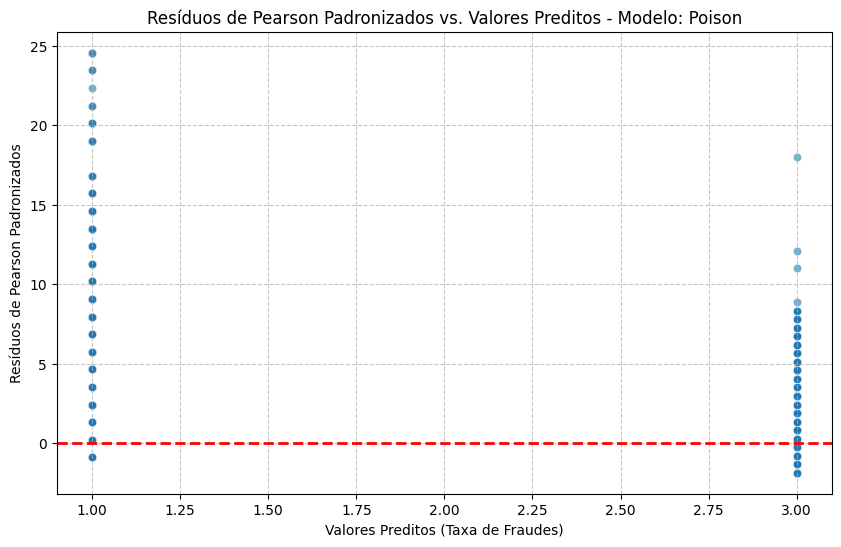

In [96]:
overdisp_plot(modelo_poison_simple, 'Poison')

In [97]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=X, family=sm.families.Poisson(), error='ignore').fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7134
Model Family:                 Poisson   Df Model:                           47
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16469.
Date:                Mon, 02 Jun 2025   Deviance:                       24635.
Time:                        21:35:21   Pearson chi2:                 4.01e+04
No. Iterations:                    21   Pseudo R-squ. (CS):             0.6992
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -16.5941   8995.249     -0.002      0.999   -1.76e+04    1.76e+04
total_amount                             4.511e-05   1.72e-06     26.280      0.000    4.17e-05    4.85e-05
max_amount                               3.917e-05   1.97e-05      1.986      0.047    5.07e-07    7.78e-05
mean_current_age                            0.1024      0.024      4.214      0.000       0.055       0.150
max_current_age                             0.0113      0.009      1.250      0.211      -0.006       0.029
min_current_age                             0.0109      0.008      1.379      0.168      -0.005       0.026
mean_per_capita_income                    2.56e-05   4.03e-05      0.635      0.525   -5.34e-05       0.000
max_per_capita_income                   -7.957e-07   4.04e-07     -1.968      0.049   -1.59e-06    -3.1e-09
min_per_capita_income                   -2.025e-05   1.72e-05     -1.177      0.239   -5.39e-05    1.35e-05
mean_total_debt                          1.938e-05   7.69e-06      2.522      0.012    4.32e-06    3.44e-05
max_total_debt                          -3.598e-07   1.95e-07     -1.850      0.064   -7.41e-07    2.14e-08
min_total_debt                             -0.0001      0.237     -0.000      1.000      -0.465       0.465
mean_credit_score                           0.0253      0.005      4.828      0.000       0.015       0.036
min_credit_score                            0.0192      0.004      5.228      0.000       0.012       0.026
mean_num_credit_cards                       1.7344      0.238      7.294      0.000       1.268       2.200
max_num_credit_cards                       -0.0217      0.029     -0.742      0.458      -0.079       0.036
min_num_credit_cards                       -5.3386   8995.248     -0.001      1.000   -1.76e+04    1.76e+04
mean_credit_limit                          -0.0002   3.81e-05     -6.155      0.000      -0.000      -0.000
max_credit_limit                        -7.902e-07   4.64e-07     -1.704      0.088    -1.7e-06    1.19e-07
gender_male                                 0.2186      0.641      0.341      0.733      -1.038       1.475
card_brand_mastercard                       0.1843      1.686      0.109      0.913      -3.121       3.489
card_brand_visa                            -4.4696      1.673     -2.671      0.008      -7.749      -1.190
card_brand_discover                        -0.4167      1.959     -0.213      0.832      -4.255       3.422
card_brand_amex                            -3.7619      1.813     -2.075      0.038      -7.316      -0.208
card_type_debit_prepaid                     1.7100      2.002      0.854      0.393      -2.214       5.634
card_type_debit                            -1.1579      1.8

In [98]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.016     
Dependent Variable:     ystar            AIC:                         65113.0260
Date:                   2025-06-02 21:35 BIC:                         65119.9054
No. Observations:       7182             Log-Likelihood:              -32556.   
Df Model:               1                F-statistic:                 114.9     
Df Residuals:           7181             Prob (F-statistic):          1.29e-26  
R-squared (uncentered): 0.016            Scale:                       506.80    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.1843         0.1105       10.7209       0.0000       0.9677       1.4008
--

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

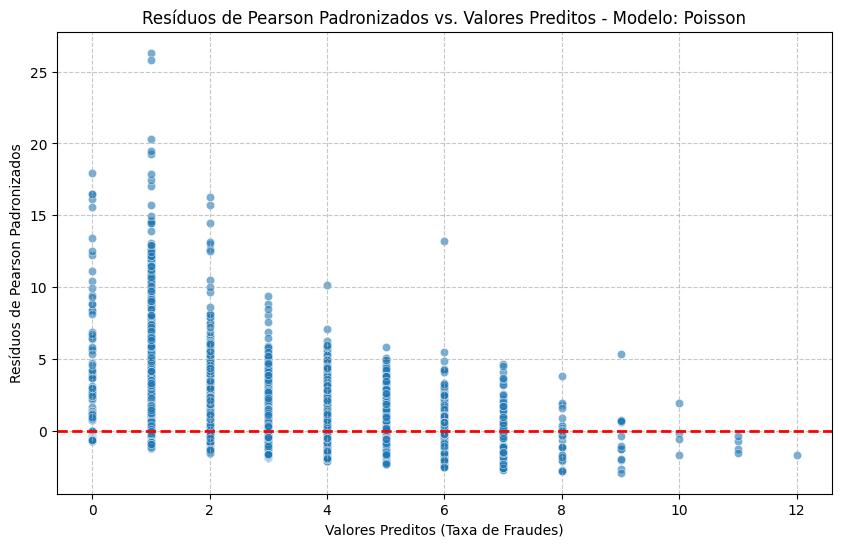

In [99]:
overdisp_plot(modelo_poison_complete, 'Poisson')

In [100]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('max_amount') + Q('mean_current_age') + Q('max_current_age') + Q('min_current_age') + Q('mean_per_capita_income') + Q('max_per_capita_income') + Q('min_per_capita_income') + Q('mean_total_debt') + Q('max_total_debt') + Q('min_total_debt') + Q('mean_credit_score') + Q('min_credit_score') + Q('mean_num_credit_cards') + Q('max_num_credit_cards') + Q('min_num_credit_cards') + Q('mean_credit_limit') + Q('max_credit_limit') + Q('gender_male') + Q('card_brand_mastercard') + Q('card_brand_visa') + Q('card_brand_discover') + Q('card_brand_amex') + Q('card_type_debit_prepaid') + Q('card_type_debit') + Q('card_type_credit') + Q('has_chip_yes') + Q('online_sales_no') + Q('has_error_yes') + Q('category_professional_business_services') + Q('category_retail_general_department') + Q('category_food_beverage') + Q('category_financial_insurance') + Q('category_retail_clothing_accessories') + Q('category_retail_home_garden') + Q(

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7150
Model Family:                 Poisson   Df Model:                           31
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16476.
Date:                Mon, 02 Jun 2025   Deviance:                       24649.
Time:                        21:35:36   Pearson chi2:                 4.02e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.6986
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      -22.9833      4.316     -5.325      0.000     -31.443     -14.523
Q('total_amount')                             4.364e-05   1.63e-06     26.842      0.000    4.05e-05    4.68e-05
Q('max_amount')                               4.139e-05   1.97e-05      2.103      0.035    2.81e-06       8e-05
Q('mean_current_age')                            0.1221      0.021      5.776      0.000       0.081       0.164
Q('max_per_capita_income')                   -8.538e-07   3.86e-07     -2.213      0.027   -1.61e-06   -9.75e-08
Q('mean_total_debt')                          2.084e-05   7.03e-06      2.963      0.003    7.06e-06    3.46e-05
Q('mean_credit_score')                           0.0261      0.005      5.002      0.000       0.016       0.036
Q('min_credit_score')                            0.0184      0.004      5.078      0.000       0.011       0.026
Q('mean_num_credit_cards')                       1.7164      0.237      7.257      0.000       1.253       2.180
Q('mean_credit_limit')                          -0.0002   2.82e-05     -8.606      0.000      -0.000      -0.000
Q('card_brand_visa')                            -4.6064      0.626     -7.362      0.000      -5.833      -3.380
Q('card_brand_amex')                            -3.4407      1.159     -2.970      0.003      -5.711      -1.170
Q('card_type_debit_prepaid')                     2.5930      1.197      2.167      0.030       0.248       4.938
Q('online_sales_no')                           -23.2213      0.895    -25.957      0.000     -24.975     -21.468
Q('has_error_yes')                               4.7987      1.759      2.728      0.006       1.351       8.246
Q('category_professional_business_services')    -7.4211      1.848     -4.017      0.000     -11.042      -3.800
Q('category_retail_general_department')          9.9573      1.114      8.939      0.000       7.774      12.141
Q('category_food_beverage')                      9.7963      0.782     12.530      0.000       8.264      11.329
Q('category_retail_clothing_accessories')        4.8542      2.427      2.000      0.045       0.098       9.611
Q('category_retail_home_garden')                 8.0128      1.678      4.775      0.000       4.724      11.302
Q('category_health_medical')                     3.6181      1.210      2.991      0.003       1.247       5.989
Q('category_construction_contractors')          27.7471      9.486      2.925      0.003       9.155      46.339
Q('category_technology_telecommunications')     -9.8047      1.699     -5.772      0.000     -13.134      -6.475
Q('category_arts_entertainment_recreation')     -6.5312      1.237     -5.282      0.000      -8.955      -4.108
Q('category_transportation_logis

Aplicando a analise de superdispersão e a "plotagem" do gráfico de valores preditos X os residuos ajustados para comparar como o modelo se comporta em relação a superdispersão.

In [101]:
overdisp(modelo_poisson_stepswise, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.016     
Dependent Variable:     ystar            AIC:                         65127.5164
Date:                   2025-06-02 21:35 BIC:                         65134.3958
No. Observations:       7182             Log-Likelihood:              -32563.   
Df Model:               1                F-statistic:                 114.8     
Df Residuals:           7181             Prob (F-statistic):          1.41e-26  
R-squared (uncentered): 0.016            Scale:                       507.83    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.1851         0.1106       10.7124       0.0000       0.9682       1.4020
--

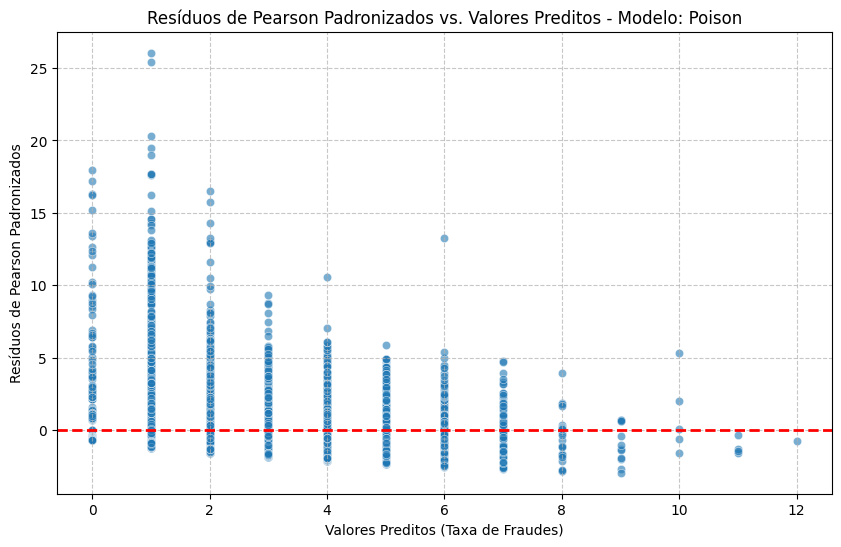

In [102]:
overdisp_plot(modelo_poisson_stepswise, 'Poison')

TODO: Rever

O gráfico evidencia uma caracteristica marcante no problema de superdispersão que é o padrão de "cone" extremamente acentuado, que se abre drasticamente quando os valores preditos se aproximam de zero. Caso o modelo fosse bem ajustado, eperariamos que os resudios estivessem distribuidos em torno de zero, sem padrões visiveis e com uma variancia mais ou menos constante.

In [103]:
summary_col([modelo_poison_simple, modelo_poison_complete, modelo_poisson_stepswise],
            model_names=["Poisson Simples", "Poisson Completo", "Poisson StepWise"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,Poisson Simples,Poisson Completo,Poisson StepWise
Intercept,-0.2035***,-16.5941,-22.9833***
,(0.0164),(8995.2492),(4.3163)
previous_frauds,1.4491***,1.3799***,
,(0.0195),(0.0197),
total_amount,,0.0000***,
,,(0.0000),
max_amount,,0.0000**,
,,(0.0000),
mean_current_age,,0.1024***,
,,(0.0243),


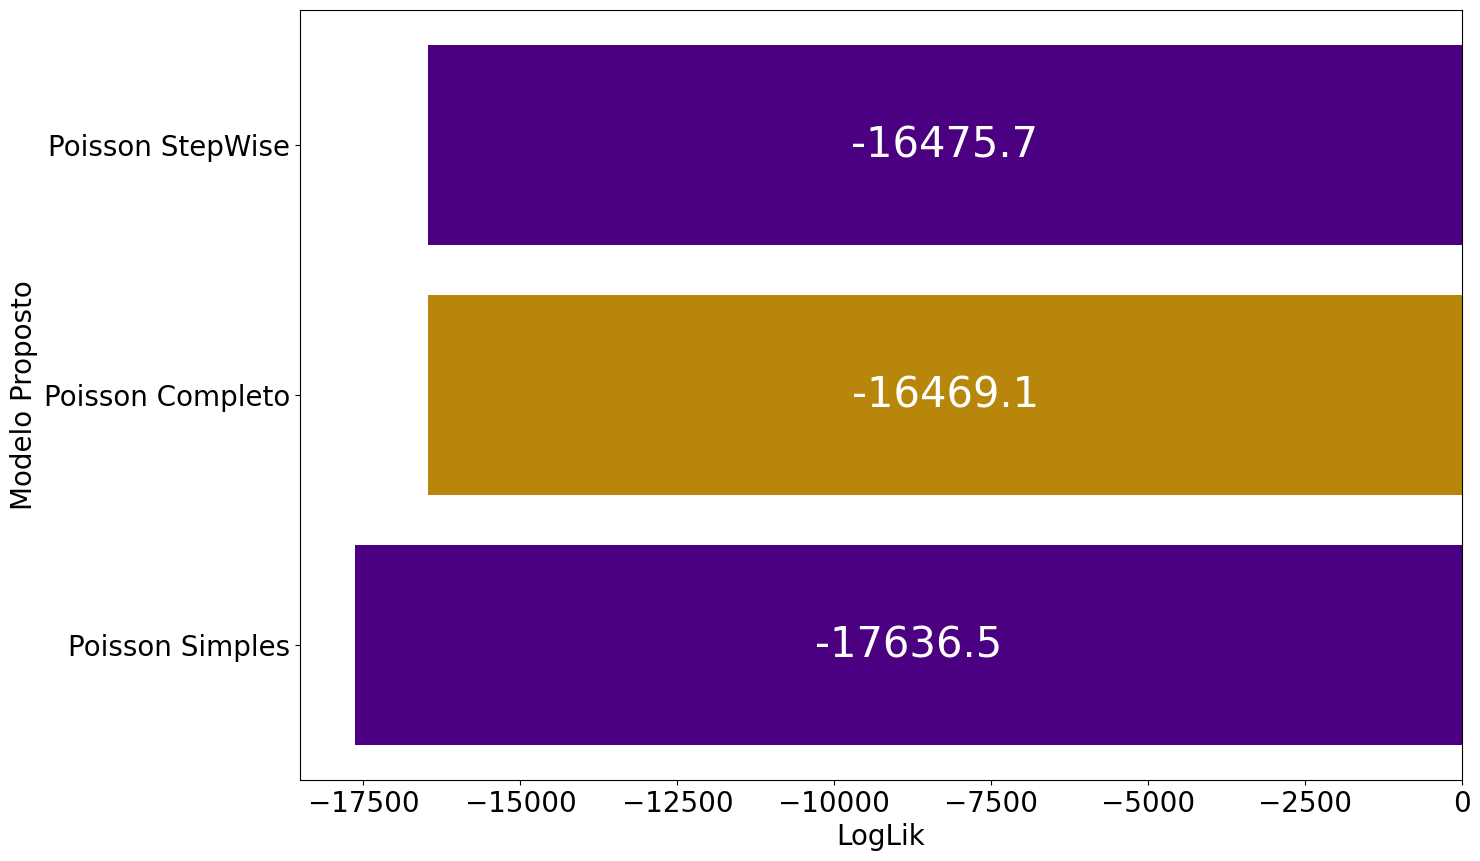

In [104]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf]
})

### Binomial Negative (Poisson-Gama)

In [105]:
result_tests = {}
for column in X.drop(columns=['frauds']).columns[1:]:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.NegativeBinomial()).fit(disp=True)
  result_tests[column] = model_test.llf
column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'category_personal_services'

In [106]:
modelo_binomialneg_simples = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.NegativeBinomial()).fit(disp=True)
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7180
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13066.
Date:                Mon, 02 Jun 2025   Deviance:                       13388.
Time:                        21:36:07   Pearson chi2:                 1.60e+04
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0008075
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.6632      0.037     17.914      0.000       0.591       0.736
category_personal_services    -7.6121      3.145     -2.420      0.016     -13.776      -1.448
==============================================================================================
"""

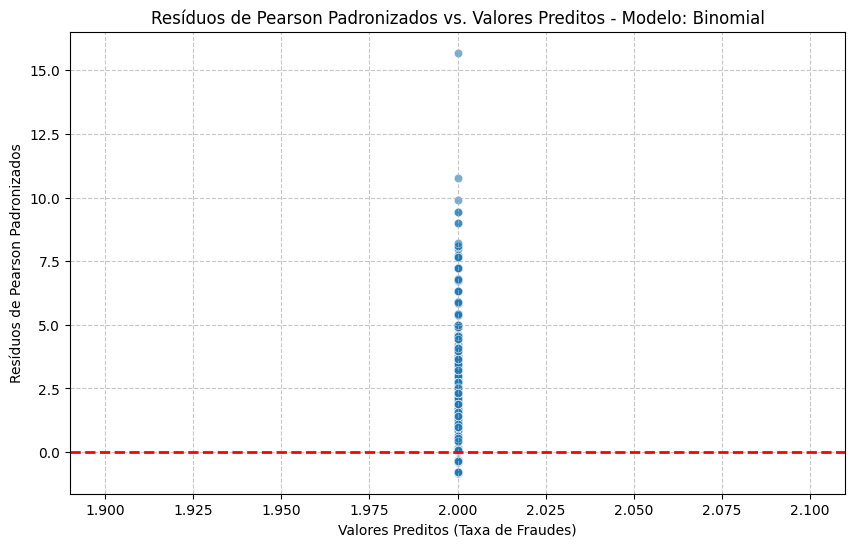

In [107]:
overdisp_plot(modelo_binomialneg_simples, 'Binomial')

In [108]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7134
Model Family:        NegativeBinomial   Df Model:                           47
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11486.
Date:                Mon, 02 Jun 2025   Deviance:                       10229.
Time:                        21:36:15   Pearson chi2:                 1.79e+04
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3564
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -22.7256   1.27e+04     -0.002      0.999   -2.48e+04    2.48e+04
total_amount                             3.734e-05   3.06e-06     12.192      0.000    3.13e-05    4.33e-05
max_amount                               5.789e-05   3.74e-05      1.548      0.122   -1.54e-05       0.000
mean_current_age                            0.0952      0.044      2.163      0.031       0.009       0.182
max_current_age                             0.0003      0.016      0.018      0.986      -0.031       0.032
min_current_age                            -0.0080      0.014     -0.556      0.578      -0.036       0.020
mean_per_capita_income                   5.083e-05   7.23e-05      0.703      0.482   -9.08e-05       0.000
max_per_capita_income                   -1.866e-07   7.14e-07     -0.261      0.794   -1.59e-06    1.21e-06
min_per_capita_income                   -5.552e-05   3.06e-05     -1.817      0.069      -0.000    4.36e-06
mean_total_debt                          2.579e-05   1.39e-05      1.859      0.063   -1.41e-06     5.3e-05
max_total_debt                          -6.638e-07    3.4e-07     -1.954      0.051   -1.33e-06    2.17e-09
min_total_debt                          -9.833e-05      0.331     -0.000      1.000      -0.649       0.649
mean_credit_score                           0.0335      0.009      3.581      0.000       0.015       0.052
min_credit_score                            0.0287      0.007      4.392      0.000       0.016       0.041
mean_num_credit_cards                       2.0171      0.423      4.767      0.000       1.188       2.846
max_num_credit_cards                       -0.0024      0.050     -0.048      0.962      -0.101       0.096
min_num_credit_cards                       -6.1710   1.27e+04     -0.000      1.000   -2.48e+04    2.48e+04
mean_credit_limit                          -0.0003   6.86e-05     -4.726      0.000      -0.000      -0.000
max_credit_limit                        -1.568e-06   8.26e-07     -1.899      0.058   -3.19e-06    5.04e-08
gender_male                                -1.0646      1.158     -0.919      0.358      -3.335       1.206
card_brand_mastercard                       1.0903      3.066      0.356      0.722      -4.918       7.099
card_brand_visa                            -4.3677      3.037     -1.438      0.150     -10.320       1.585
card_brand_discover                        -2.8997      3.548     -0.817      0.414      -9.854       4.054
card_brand_amex                            -2.5896      3.297     -0.785      0.432      -9.051       3.872
card_type_debit_prepaid                    -0.8299      3.606     -0.230      0.818      -7.898       6.238
card_type_debit                            -2.8809      3.4

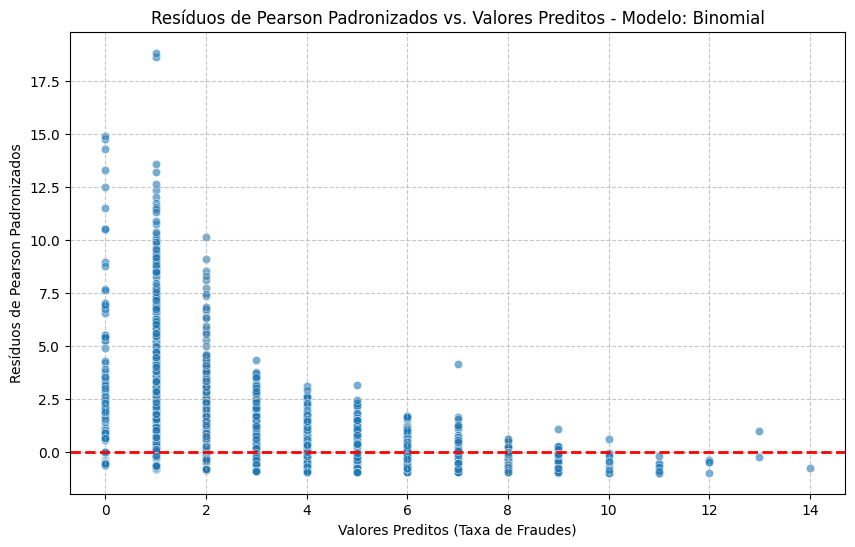

In [109]:
overdisp_plot(modelo_binomialneg_completo, 'Binomial')

In [110]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('max_amount') + Q('mean_current_age') + Q('max_current_age') + Q('min_current_age') + Q('mean_per_capita_income') + Q('max_per_capita_income') + Q('min_per_capita_income') + Q('mean_total_debt') + Q('max_total_debt') + Q('min_total_debt') + Q('mean_credit_score') + Q('min_credit_score') + Q('mean_num_credit_cards') + Q('max_num_credit_cards') + Q('min_num_credit_cards') + Q('mean_credit_limit') + Q('max_credit_limit') + Q('gender_male') + Q('card_brand_mastercard') + Q('card_brand_visa') + Q('card_brand_discover') + Q('card_brand_amex') + Q('card_type_debit_prepaid') + Q('card_type_debit') + Q('card_type_credit') + Q('has_chip_yes') + Q('online_sales_no') + Q('has_error_yes') + Q('category_professional_business_services') + Q('category_retail_general_department') + Q('category_food_beverage') + Q('category_financial_insurance') + Q('category_retail_clothing_accessories') + Q('category_retail_home_garden') + Q(

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 7182
Model:                            GLM   Df Residuals:                     7158
Model Family:        NegativeBinomial   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11500.
Date:                Mon, 02 Jun 2025   Deviance:                       10258.
Time:                        21:36:28   Pearson chi2:                 1.81e+04
No. Iterations:                    13   Pseudo R-squ. (CS):             0.3538
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      -28.1791      7.574     -3.721      0.000     -43.024     -13.334
Q('total_amount')                             3.635e-05   2.61e-06     13.935      0.000    3.12e-05    4.15e-05
Q('mean_current_age')                            0.0895      0.038      2.364      0.018       0.015       0.164
Q('mean_total_debt')                          2.526e-05   1.25e-05      2.016      0.044    7.01e-07    4.98e-05
Q('mean_credit_score')                           0.0319      0.009      3.439      0.001       0.014       0.050
Q('min_credit_score')                            0.0328      0.006      5.265      0.000       0.021       0.045
Q('mean_num_credit_cards')                       2.0770      0.419      4.955      0.000       1.256       2.899
Q('mean_credit_limit')                          -0.0003   4.73e-05     -6.927      0.000      -0.000      -0.000
Q('card_brand_visa')                            -4.9910      1.107     -4.508      0.000      -7.161      -2.821
Q('online_sales_no')                           -28.6156      1.592    -17.979      0.000     -31.735     -25.496
Q('category_professional_business_services')    -8.5880      3.371     -2.548      0.011     -15.195      -1.981
Q('category_retail_general_department')         10.7493      2.007      5.356      0.000       6.816      14.683
Q('category_food_beverage')                     11.9951      1.342      8.941      0.000       9.366      14.625
Q('category_retail_home_garden')                 7.3010      3.033      2.407      0.016       1.356      13.246
Q('category_health_medical')                     6.3852      2.143      2.980      0.003       2.186      10.585
Q('category_technology_telecommunications')    -10.3346      3.007     -3.437      0.001     -16.228      -4.441
Q('category_arts_entertainment_recreation')     -7.1807      2.189     -3.280      0.001     -11.471      -2.890
Q('category_transportation_logistics')          -5.9430      1.609     -3.694      0.000      -9.096      -2.790
Q('category_retail_specialty')                  26.6084      2.505     10.621      0.000      21.698      31.519
Q('category_travel_hospitality')               -19.7551      5.209     -3.793      0.000     -29.964      -9.546
Q('category_government_utilities')             -10.2248      2.972     -3.440      0.001     -16.051      -4.399
Q('category_sports_recreation')                 -9.6694      4.364     -2.216      0.027     -18.223      -1.116
Q('category_manufacturing_industrial')          -9.1759      3.400     -2.698      0.007     -15.840      -2.511
Q('previous_frauds')                             1.4510      0.032     44.903      0.000       1.388       1.514
================================

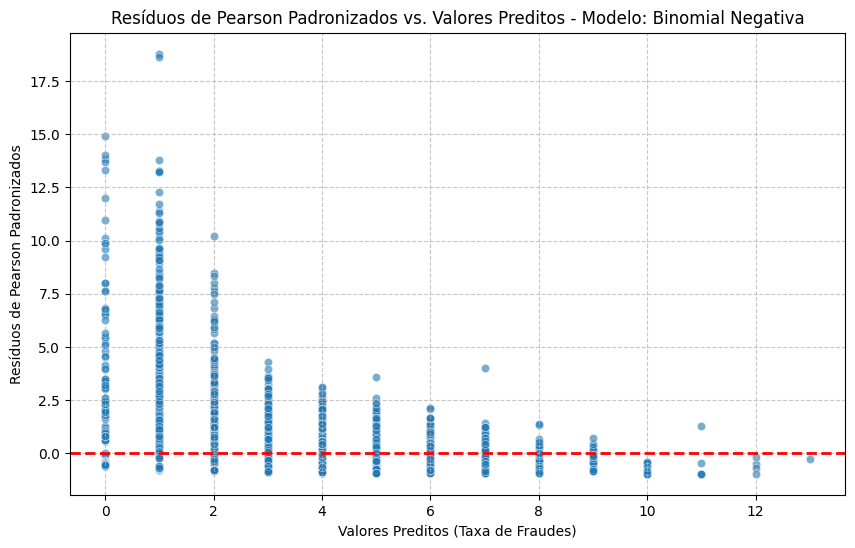

In [111]:
overdisp_plot(modelo_binomialneg_stepwise, 'Binomial Negativa')

In [112]:
lrtest([modelo_binomialneg_completo, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -28.88
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


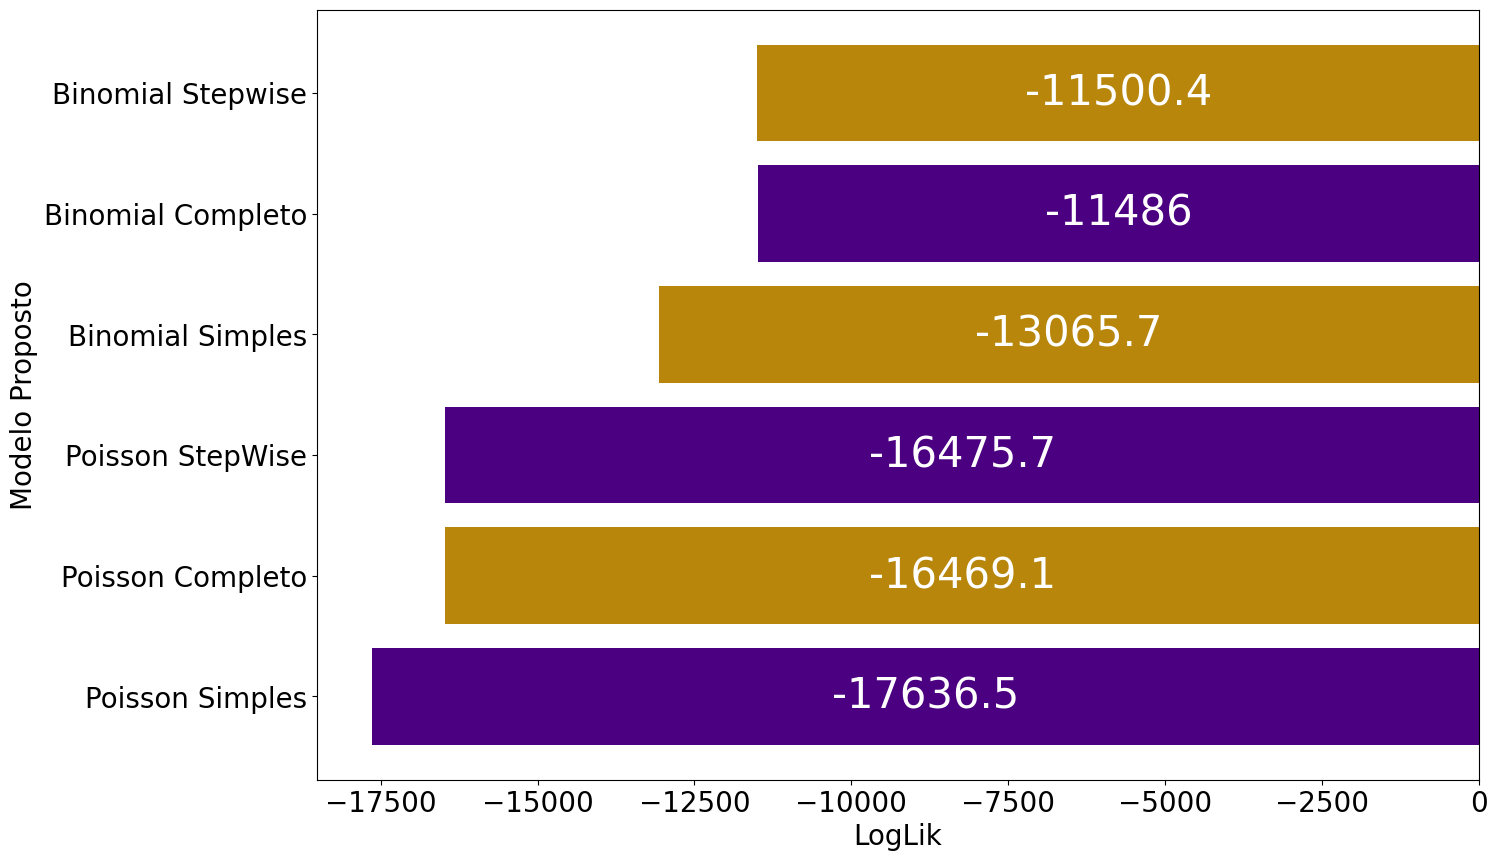

In [113]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise', 'Binomial Simples', 'Binomial Completo', 'Binomial Stepwise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf, modelo_binomialneg_simples.llf, modelo_binomialneg_completo.llf, modelo_binomialneg_stepwise.llf]
})

### Zero Inflated Poison

In [114]:
X_log = X.drop(columns=['frauds']).copy()
for column in X_log.columns:
  X_log[column] = np.log(X_log[column] + 1)
X_log.head()

,total_amount,max_amount,mean_current_age,max_current_age,min_current_age,mean_per_capita_income,max_per_capita_income,min_per_capita_income,mean_total_debt,max_total_debt,...,category_technology_telecommunications,category_arts_entertainment_recreation,category_transportation_logistics,category_retail_specialty,category_travel_hospitality,category_government_utilities,category_sports_recreation,category_manufacturing_industrial,category_personal_services,previous_frauds
0,10.433245,7.051518,4.033294,4.624973,3.367296,10.079570,11.830863,0.0,10.949226,13.043006,...,0.019803,0.019803,0.231112,0.019803,0.0,0.009950,0.019803,0.00000,0.00000,0.000000
1,11.094053,7.178324,4.042953,4.605170,3.367296,10.102210,12.002401,0.0,10.900173,13.043006,...,0.019803,0.048790,0.223144,0.009950,0.0,0.009950,0.019803,0.00995,0.00000,0.000000
2,10.661530,7.252862,4.032200,4.624973,3.401197,10.086920,12.002401,0.0,10.930522,13.043006,...,0.029559,0.009950,0.207014,0.029559,0.0,0.019803,0.009950,0.00000,0.00995,0.693147
3,10.959713,6.731364,4.028369,4.605170,3.367296,10.070067,12.002401,0.0,10.920868,13.043006,...,0.029559,0.048790,0.207014,0.009950,0.0,0.029559,0.009950,0.00995,0.00995,0.000000
4,10.615313,6.619086,4.013545,4.624973,3.367296,10.073814,11.420602,0.0,10.986092,13.043006,...,0.029559,0.009950,0.215111,0.039221,0.0,0.029559,0.000000,0.00000,0.00995,0.000000


In [115]:
exclude_columns = X_log.isna().sum().reset_index().rename(columns={0:'missing'}).query('missing > 0')['index'].to_list()
X_droped = X.drop(columns=exclude_columns)

In [116]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X_droped.drop(columns=['frauds']))

X_scaler = pd.DataFrame(X_scaler, columns=X_droped.drop(columns=['frauds']).columns)
X_scaler.head()

,total_amount,max_amount,mean_current_age,max_current_age,min_current_age,mean_per_capita_income,max_per_capita_income,min_per_capita_income,mean_total_debt,max_total_debt,...,category_technology_telecommunications,category_arts_entertainment_recreation,category_transportation_logistics,category_retail_specialty,category_travel_hospitality,category_government_utilities,category_sports_recreation,category_manufacturing_industrial,category_personal_services,previous_frauds
0,-1.961996,0.111892,2.075043,0.641835,1.577003,-0.301128,-0.141026,-0.062111,-0.488883,0.358947,...,-1.195256,0.190061,1.013614,-0.579047,-0.194574,-2.752023,3.581870,-0.665573,-2.312583,-0.759199
1,0.470598,0.467660,2.916453,-0.681829,1.577003,1.127281,0.818642,-0.062111,-1.856659,0.358947,...,-1.195256,2.053993,0.459260,-1.363711,-0.194574,-2.752023,3.581870,0.212646,-2.312583,-0.759199
2,-1.295771,0.698830,1.980199,0.641835,2.127051,0.159088,0.818642,-0.062111,-1.018345,0.358947,...,0.186861,-0.431249,-0.649448,0.205616,-0.194574,-1.133133,1.473437,-0.665573,-0.182682,1.317178
3,-0.161777,-0.609035,1.649108,-0.681829,1.577003,-0.891112,0.818642,-0.062111,-1.287758,0.358947,...,0.186861,2.053993,-0.649448,-1.363711,-0.194574,0.485757,1.473437,0.212646,-0.182682,-0.759199
4,-1.443198,-0.811944,0.379614,0.641835,1.577003,-0.659162,-1.866840,-0.062111,0.584145,0.358947,...,0.186861,-0.431249,-0.095094,0.990280,-0.194574,0.485757,-0.634996,-0.665573,-0.182682,-0.759199


In [117]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zip_test = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False)
  result_tests[column] = modelo_zip_test.llf

column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'previous_frauds'

In [118]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [119]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False)
modelo_zip_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                 7182
Model:             ZeroInflatedPoisson   Df Residuals:                     7180
Method:                            MLE   Df Model:                            1
Date:                 Mon, 02 Jun 2025   Pseudo R-squ.:                 0.07669
Time:                         21:37:04   Log-Likelihood:                -11594.
converged:                        True   LL-Null:                       -12558.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
inflate_const               0.6583      0.029     22.586      0.000       0.601       0.715
inflate_previous_frauds    -1.1225      0.028    -40.357      0.000      -1.177      -1.068
const                       1.5445      0.011    135.956      0.000       1.522       1.567
previous_frauds             0.0501      0.010      5.223      0.000       0.031       0.069
===========================================================================================
"""

In [120]:
vuong_test(modelo_poison_simple, modelo_zip_simples)

Optimization terminated successfully.
         Current function value: 2.455648
         Iterations 6
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -28.053
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [121]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [122]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False)
modelo_zip_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                 7182
Model:             ZeroInflatedPoisson   Df Residuals:                     7134
Method:                            MLE   Df Model:                           47
Date:                 Mon, 02 Jun 2025   Pseudo R-squ.:                  0.1215
Time:                         21:37:13   Log-Likelihood:                -11032.
converged:                       False   LL-Null:                       -12558.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.6770     23.410      0.029      0.977     -45.206      46.560
inflate_total_amount                               -0.5577      0.075     -7.484      0.000      -0.704      -0.412
inflate_max_amount                                  0.0389      0.031      1.255      0.210      -0.022       0.100
inflate_mean_current_age                           -0.0778      0.053     -1.466      0.143      -0.182       0.026
inflate_max_current_age                             0.0478      0.045      1.051      0.293      -0.041       0.137
inflate_min_current_age                            -0.0090      0.048     -0.187      0.852      -0.104       0.086
inflate_mean_per_capita_income                     -0.0613      0.051     -1.200      0.230      -0.161       0.039
inflate_max_per_capita_income                       0.0023      0.036      0.064      0.949      -0.068       0.072
inflate_min_per_capita_income                       0.0619      0.038      1.632      0.103      -0.012       0.136
inflate_mean_total_debt                            -0.0028      0.051     -0.054      0.957      -0.103       0.098
inflate_max_total_debt                              0.0417      0.031      1.332      0.183      -0.020       0.103
inflate_min_total_debt                              0.0926   1532.533   6.04e-05      1.000   -3003.617    3003.802
inflate_mean_credit_score                          -0.0635      0.035     -1.834      0.067      -0.131       0.004
inflate_min_credit_score                           -0.0855      0.065     -1.323      0.186      -0.212       0.041
inflate_mean_num_credit_cards                      -0.0856      0.043     -1.970      0.049      -0.171      -0.000
inflate_max_num_credit_cards                       -0.0347      0.033     -1.040      0.299      -0.100       0.031
inflate_min_num_credit_cards                       -0.0040     25.630     -0.000      1.000     -50.238      50.230
inflate_mean_credit_limit                           0.1987      0.056      3.519      0.000       0.088       0.309
inflate_max_credit_limit                            0.0213      0.032      0.669      0.504      -0.041       0.084
inflate_gender_male                                 0.0173      0.031      0.554      0.579      -0.044       0.079
inflate_card_brand_mastercard                      -0.0219      0.097     -0.225      0.822      -0.212       0.168
inflate_card_brand_visa                             0.0075      0.094      0.079      0.937      -0.177       0.192
inflate_card_brand_discover                         0.0631      0.037      1.686      0.092      -0.010       0.137
inflate_card_brand_amex                            -0.0054      0.059     -0.090      0.928      -0.122       0.111
inflate_card_type_debit_prepaid                    -0.0193      0.072     -0.268      0.788      -0.

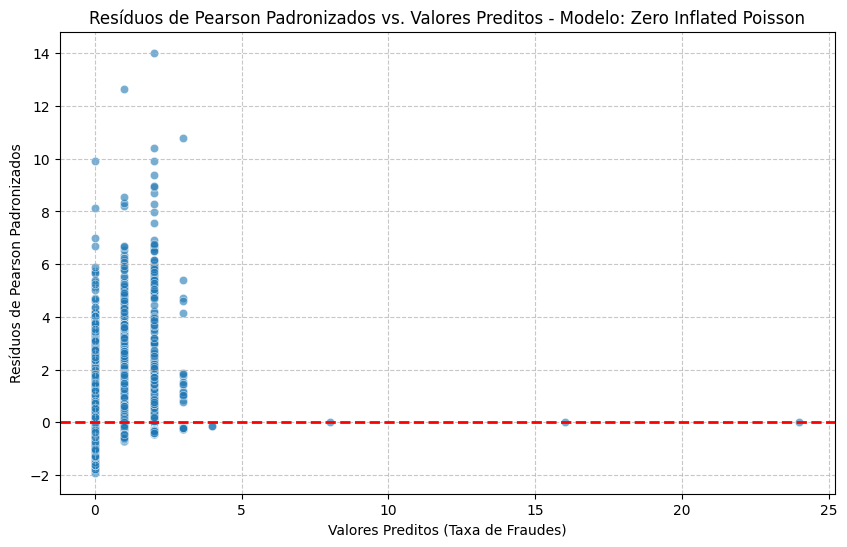

In [123]:
overdisp_plot(modelo_zip_complete, 'Zero Inflated Poisson')

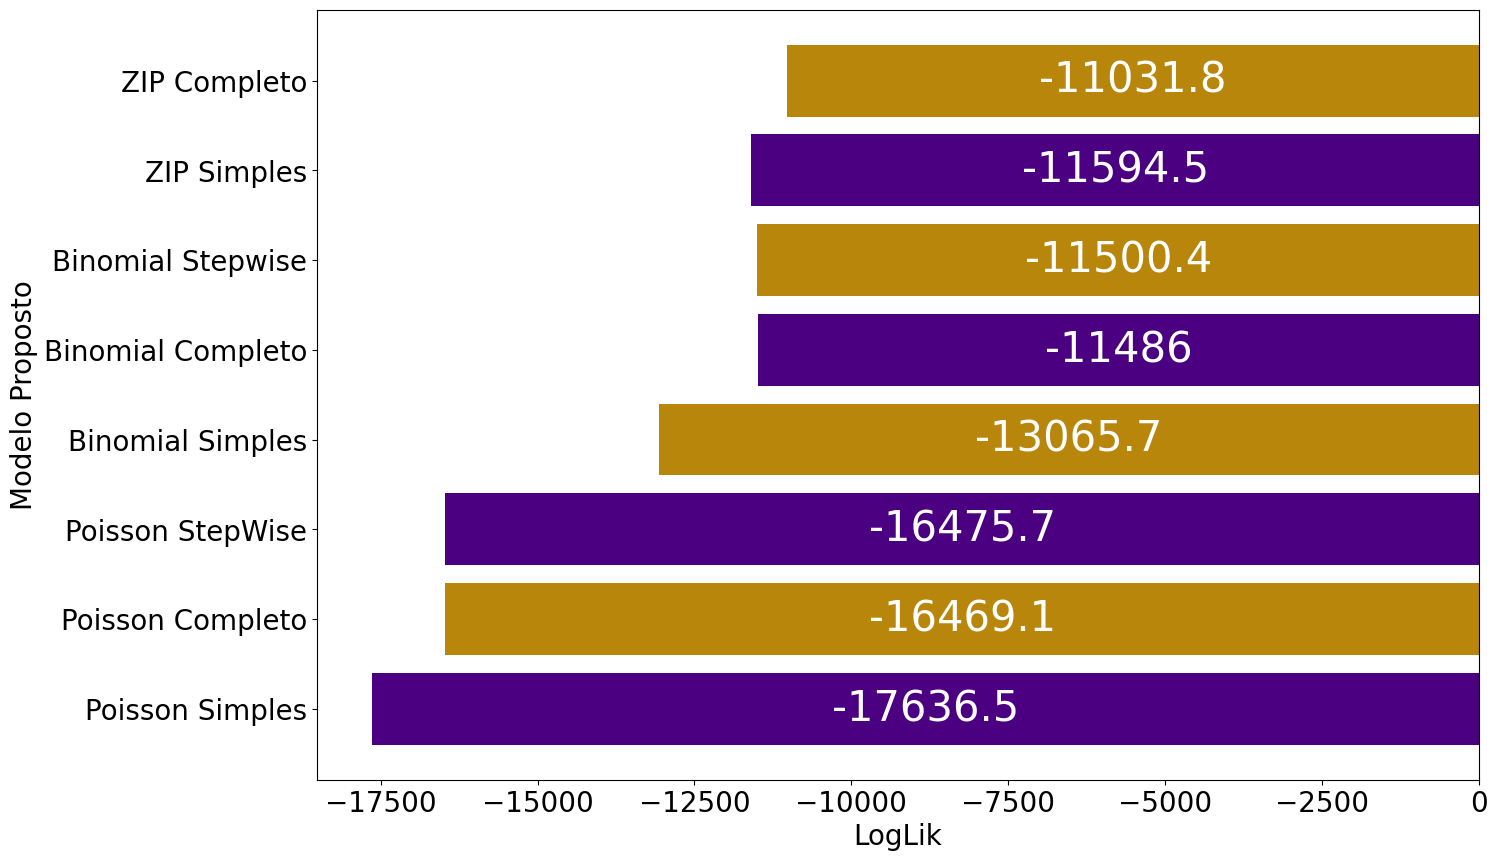

In [124]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf
      ]
})

In [125]:
df_features_zip_complete = modelo_zip_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x!='const', df_features_zip_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x!='const', df_features_zip_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
['total_amount', 'max_amount', 'max_current_age', 'mean_total_debt', 'mean_credit_score', 'min_credit_score', 'mean_num_credit_cards', 'max_num_credit_cards', 'card_brand_visa', 'card_brand_amex', 'online_sales_no', 'has_error_yes', 'category_retail_general_department', 'category_food_beverage', 'category_retail_home_garden', 'category_technology_telecommunications', 'category_retail_specialty', 'category_travel_hospitality', 'category_government_utilities', 'category_sports_recreation', 'category_manufacturing_industrial', 'category_personal_services']
Exogenas Inflado
['total_amount', 'mean_num_credit_cards', 'mean_credit_limit', 'online_sales_no', 'category_food_beverage', 'category_technology_telecommunications', 'category_arts_entertainment_recreation', 'category_transportation_logistics', 'category_retail_specialty', 'category_travel_hospitality', 'previous_frauds']


In [126]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zip_complete_filter = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2).fit(disp=False)
modelo_zip_complete_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                 7182
Model:             ZeroInflatedPoisson   Df Residuals:                     7159
Method:                            MLE   Df Model:                           22
Date:                 Mon, 02 Jun 2025   Pseudo R-squ.:                  0.1173
Time:                         21:37:40   Log-Likelihood:                -11084.
converged:                       False   LL-Null:                       -12558.
Covariance Type:             nonrobust   LLR p-value:                     0.000
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
inflate_const                                      0.6703      0.030     22.195      0.000       0.611       0.729
inflate_total_amount                              -0.4716      0.055     -8.551      0.000      -0.580      -0.363
inflate_mean_num_credit_cards                     -0.1520      0.036     -4.277      0.000      -0.222      -0.082
inflate_mean_credit_limit                          0.2030      0.036      5.613      0.000       0.132       0.274
inflate_online_sales_no                            0.3428      0.039      8.895      0.000       0.267       0.418
inflate_category_food_beverage                    -0.2827      0.039     -7.164      0.000      -0.360      -0.205
inflate_category_technology_telecommunications     0.1346      0.038      3.520      0.000       0.060       0.209
inflate_category_arts_entertainment_recreation     0.2961      0.050      5.964      0.000       0.199       0.393
inflate_category_transportation_logistics          0.1885      0.040      4.688      0.000       0.110       0.267
inflate_category_retail_specialty                 -0.2332      0.054     -4.327      0.000      -0.339      -0.128
inflate_category_travel_hospitality                0.1230      0.061      2.004      0.045       0.003       0.243
inflate_previous_frauds                           -1.1482      0.029    -39.362      0.000      -1.205      -1.091
const                                              1.4931      0.010    145.292      0.000       1.473       1.513
total_amount                                       0.3225      0.020     16.105      0.000       0.283       0.362
max_amount                                         0.0329      0.009      3.753      0.000       0.016       0.050
max_current_age                                    0.0415      0.014      3.035      0.002       0.015       0.068
mean_total_debt                                    0.0008      0.013      0.061      0.951      -0.024       0.025
mean_credit_score                                  0.0245      0.011      2.331      0.020       0.004       0.045
min_credit_score                                   0.0522      0.019      2.808      0.005       0.016       0.089
mean_num_credit_cards                              0.0728      0.012      6.214      0.000       0.050       0.096
max_num_credit_cards                              -0.0264      0.011     -2.455      0.014      -0.047      -0.005
card_brand_visa                                   -0.0779      0.011     -7.178      0.000      -0.099      -0.057
card_brand_amex                                   -0.0402      0.011     -3.542      0.000      -0.062      -0.018
online_sales_no                                   -0.1570      0.012    -13.461      0.000      -0.180      -0.134
has_error_yes                                      0.0461      0.009      4.923      0.000       0.028       0.064
category_ret

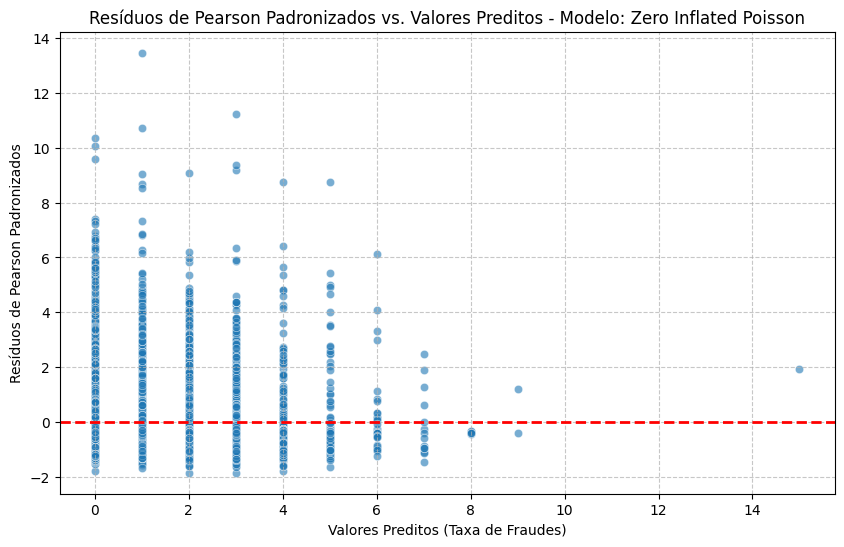

In [127]:
overdisp_plot(modelo_zip_complete_filter, 'Zero Inflated Poisson')

In [129]:
step_wise = StepwiseZeroInflated(alpha=0.05, model_type='ZIP', selection_criterion='BIC', verbose=False, validation_steps=False, fit_params=dict(disp=False), batch_size=5, early_stopping=False, parallel_features=True, n_jobs=4)
step_wise.fit(X_scaler, y)

Stepwise Selection:   0%|          | 0/100 [00:00<?, ?iter/s]

StepwiseZeroInflated(early_stopping=False, fit_params={'disp': False},
                     model_params={}, n_jobs=4, parallel_features=True,
                     selection_criterion='BIC', validation_steps=False)

In [130]:
modelo_zip_stepwise = step_wise.final_model_
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                 7182
Model:             ZeroInflatedPoisson   Df Residuals:                     7170
Method:                            MLE   Df Model:                           11
Date:                 Mon, 02 Jun 2025   Pseudo R-squ.:                  0.1106
Time:                         21:41:13   Log-Likelihood:                -11169.
converged:                        True   LL-Null:                       -12558.
Covariance Type:             nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
inflate_const                                  0.6607      0.030     22.021      0.000       0.602       0.719
inflate_previous_frauds                       -1.1424      0.029    -39.544      0.000      -1.199      -1.086
inflate_online_sales_no                        0.3084      0.037      8.387      0.000       0.236       0.380
inflate_category_food_beverage                -0.5318      0.059     -9.066      0.000      -0.647      -0.417
inflate_category_retail_general_department    -0.2611      0.054     -4.850      0.000      -0.367      -0.156
inflate_mean_num_credit_cards                 -0.0802      0.036     -2.223      0.026      -0.151      -0.009
inflate_mean_credit_limit                      0.1795      0.036      5.033      0.000       0.110       0.249
inflate_category_health_medical               -0.1241      0.032     -3.822      0.000      -0.188      -0.060
inflate_mean_credit_score                     -0.1161      0.032     -3.625      0.000      -0.179      -0.053
const                                          1.4973      0.010    146.743      0.000       1.477       1.517
total_amount                                   0.2987      0.018     16.454      0.000       0.263       0.334
category_retail_specialty                      0.1967      0.017     11.542      0.000       0.163       0.230
online_sales_no                               -0.1663      0.012    -14.387      0.000      -0.189      -0.144
category_food_beverage                         0.2370      0.021     11.522      0.000       0.197       0.277
category_retail_general_department             0.1354      0.016      8.261      0.000       0.103       0.168
mean_num_credit_cards                          0.0741      0.011      6.934      0.000       0.053       0.095
category_retail_home_garden                    0.0747      0.015      5.076      0.000       0.046       0.104
has_error_yes                                  0.0459      0.009      4.913      0.000       0.028       0.064
category_health_medical                        0.0334      0.011      3.088      0.002       0.012       0.055
category_government_utilities                 -0.0374      0.010     -3.805      0.000      -0.057      -0.018
max_amount                                     0.0327      0.009      3.720      0.000       0.015       0.050
==============================================================================================================
"""

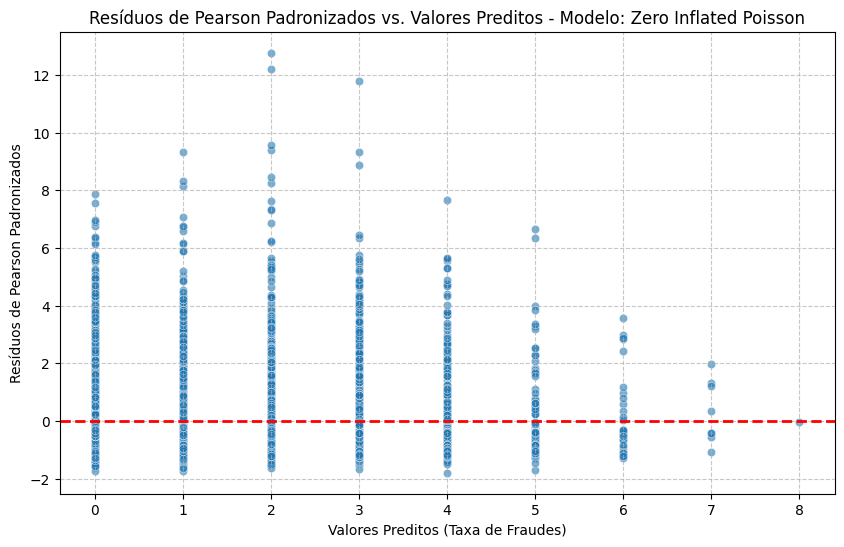

In [131]:
overdisp_plot(modelo_zip_stepwise, 'Zero Inflated Poisson')

In [133]:
lrtest([modelo_zip_stepwise, modelo_zip_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -0.0
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


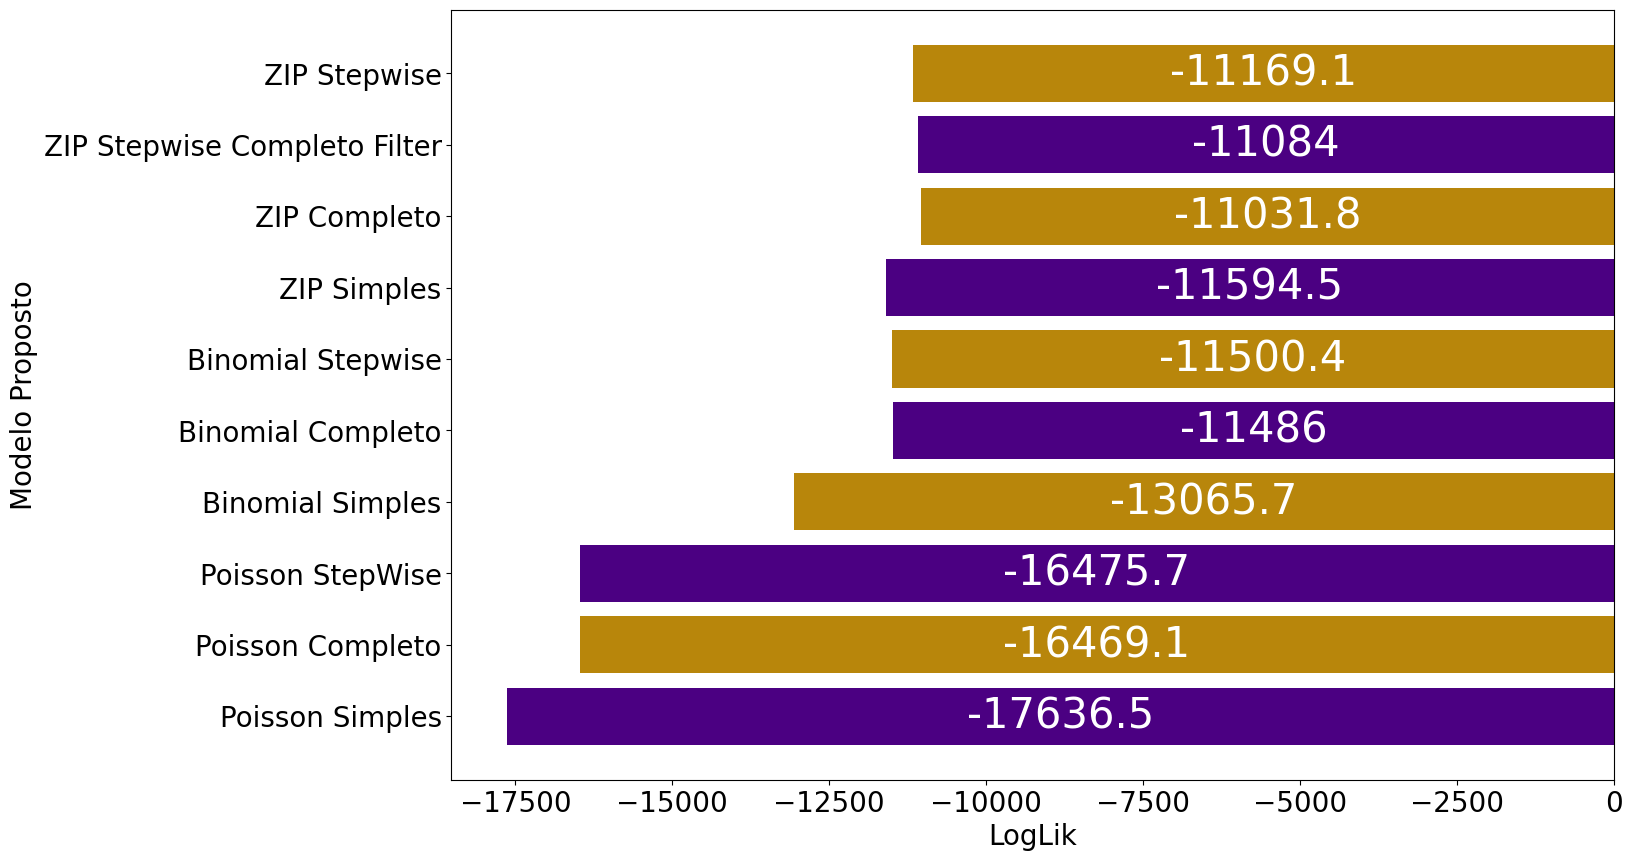

In [134]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise Completo Filter',
        'ZIP Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_complete_filter.llf,
        modelo_zip_stepwise.llf
      ]
})

### ZINB - Zero Inflated Negative Benomial

In [135]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zbneg_test = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1).fit(disp=False)
  result_tests[column] = modelo_zbneg_test.llf

column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'card_type_credit'

In [136]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [137]:
modelo_zinb_simples = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='logit').fit(disp=False)
modelo_zinb_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                 7182
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     7180
Method:                                      MLE   Df Model:                            1
Date:                           Mon, 02 Jun 2025   Pseudo R-squ.:               0.0001193
Time:                                   21:43:04   Log-Likelihood:                -11213.
converged:                                 False   LL-Null:                       -11214.
Covariance Type:                       nonrobust   LLR p-value:                    0.1019
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
inflate_const                0.2614      0.036      7.186      0.000       0.190       0.333
inflate_card_type_credit     0.0398      0.029      1.371      0.170      -0.017       0.097
const                        1.4130      0.024     59.135      0.000       1.366       1.460
card_type_credit            -0.0107      0.022     -0.480      0.631      -0.054       0.033
alpha                        0.7858      0.050     15.575      0.000       0.687       0.885
============================================================================================
"""

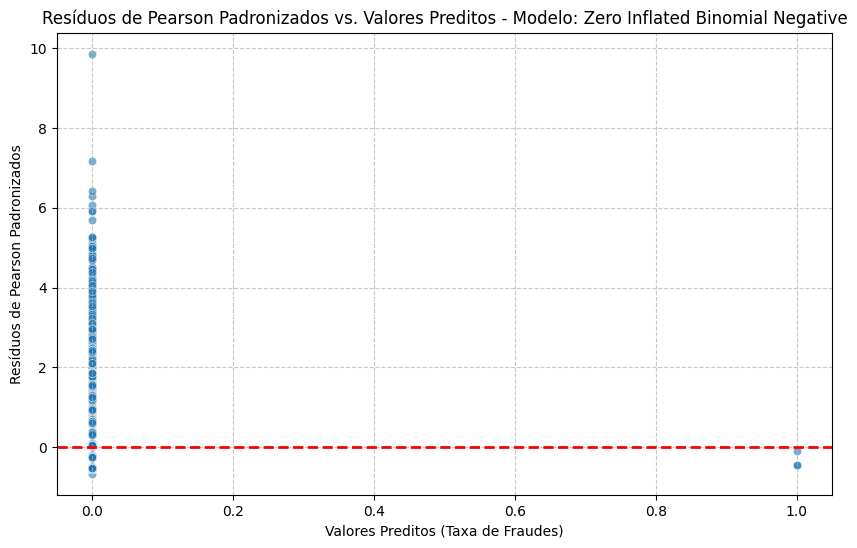

In [138]:
overdisp_plot(modelo_zinb_simples, 'Zero Inflated Binomial Negative')

In [139]:
vuong_test(modelo_binomialneg_simples, modelo_zinb_simples)

Optimization terminated successfully.
         Current function value: 1.586020
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -9.826
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [140]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [141]:
modelo_zinb_complete = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1).fit(disp=False)
modelo_zinb_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                 7182
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     7134
Method:                                      MLE   Df Model:                           47
Date:                           Mon, 02 Jun 2025   Pseudo R-squ.:                  0.1203
Time:                                   21:44:10   Log-Likelihood:                -9864.9
converged:                                 False   LL-Null:                       -11214.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                      -0.8090        nan        nan        nan         nan         nan
inflate_total_amount                                0.4858        nan        nan        nan         nan         nan
inflate_max_amount                                 -0.0116        nan        nan        nan         nan         nan
inflate_mean_current_age                           -0.0200        nan        nan        nan         nan         nan
inflate_max_current_age                             0.0986        nan        nan        nan         nan         nan
inflate_min_current_age                             0.4248        nan        nan        nan         nan         nan
inflate_mean_per_capita_income                     -0.1604        nan        nan        nan         nan         nan
inflate_max_per_capita_income                      -0.0442        nan        nan        nan         nan         nan
inflate_min_per_capita_income                       0.1225        nan        nan        nan         nan         nan
inflate_mean_total_debt                             0.0196        nan        nan        nan         nan         nan
inflate_max_total_debt                              0.0649        nan        nan        nan         nan         nan
inflate_min_total_debt                              0.0125        nan        nan        nan         nan         nan
inflate_mean_credit_score                          -0.0273        nan        nan        nan         nan         nan
inflate_min_credit_score                           -0.0726        nan        nan        nan         nan         nan
inflate_mean_num_credit_cards                      -0.1679        nan        nan        nan         nan         nan
inflate_max_num_credit_cards                       -0.0149        nan        nan        nan         nan         nan
inflate_min_num_credit_cards                       -0.0144        nan        nan        nan         nan         nan
inflate_mean_credit_limit                           0.4162        nan        nan        nan         nan         nan
inflate_max_credit_limit                           -0.0296        nan        nan        nan         nan         nan
inflate_gender_male                                 0.0731        nan        nan        nan         nan         nan
inflate_card_brand_mastercard                       0.0585        nan        nan        nan         nan         nan
inflate_card_brand_visa                             0.0660        nan        nan        nan         nan         nan
inflate_card_brand_discover                         0.0851        nan        nan        nan         nan         nan
inflate_card_brand_amex                            -0.0686        nan        nan        nan         nan         nan
inflate_ca

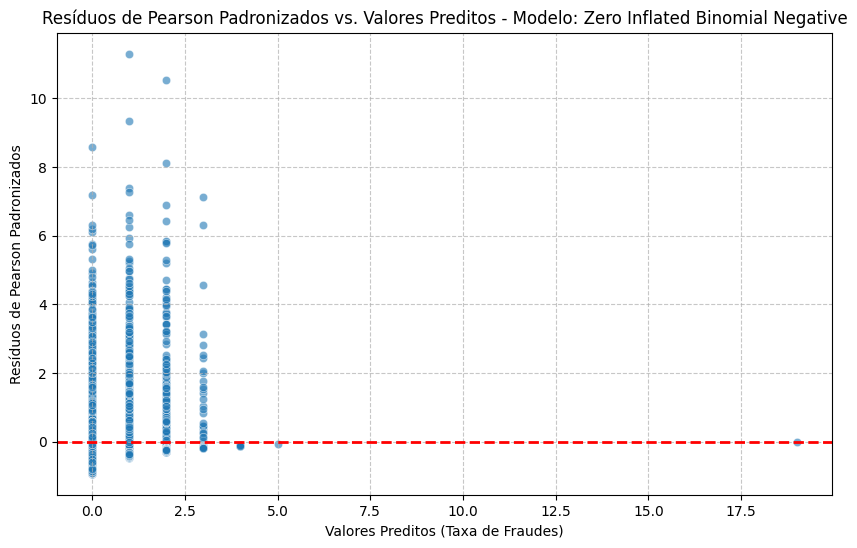

In [142]:
overdisp_plot(modelo_zinb_complete, 'Zero Inflated Binomial Negative')

In [143]:
df_features_zinp_complete = modelo_zinb_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zinp_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zinp_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
[]
Exogenas Inflado
[]


In [183]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zinb_complete_filter = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1).fit(disp=False)
modelo_zinb_complete_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                 7182
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     7181
Method:                                      MLE   Df Model:                            0
Date:                           Mon, 02 Jun 2025   Pseudo R-squ.:               4.975e-11
Time:                                   22:19:18   Log-Likelihood:                -11214.
converged:                                  True   LL-Null:                       -11214.
Covariance Type:                       nonrobust   LLR p-value:                       nan
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     0.2610      0.036      7.173      0.000       0.190       0.332
const             1.4133      0.024     59.136      0.000       1.366       1.460
alpha             0.7863      0.051     15.568      0.000       0.687       0.885
=================================================================================
"""

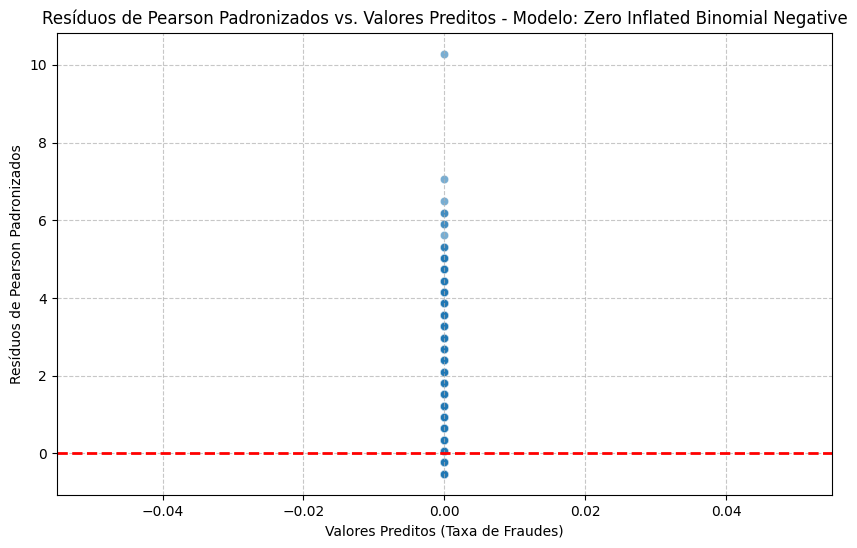

In [184]:
overdisp_plot(modelo_zinb_complete_filter, 'Zero Inflated Binomial Negative')

In [149]:
step_wise = StepwiseZeroInflated(alpha=0.05, model_type='ZINB', selection_criterion='BIC', verbose=False, validation_steps=False, model_params=dict(p=1), fit_params=dict(disp=False), batch_size=5, early_stopping=False, parallel_features=True, n_jobs=4)
step_wise.fit(X_scaler, y)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Stepwise Selection:   0%|          | 0/100 [00:00<?, ?iter/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d17801842f0>
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d17801854e0>
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:4206: RuntimeWarning: invalid value encountered in divide
  a = ((resid**2 / mu - 1) * mu**(-

StepwiseZeroInflated(early_stopping=False, fit_params={'disp': False},
                     model_params={'p': 1}, model_type='ZINB', n_jobs=4,
                     parallel_features=True, selection_criterion='BIC',
                     validation_steps=False)

In [151]:
modelo_zinb_stepwise = step_wise.final_model_
modelo_zinb_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 7182
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     7174
Method:                                      MLE   Df Model:                            7
Date:                           Mon, 02 Jun 2025   Pseudo R-squ.:                 0.09615
Time:                                   21:53:42   Log-Likelihood:                -10136.
converged:                                 False   LL-Null:                       -11214.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
inflate_const                         -3.5690      0.348    -10.267      0.000      -4.250      -2.888
inflate_total_amount                  -1.8472      0.263     -7.013      0.000      -2.363      -1.331
inflate_online_sales_no               -0.3213      0.112     -2.881      0.004      -0.540      -0.103
inflate_mean_num_credit_cards         -0.3148      0.108     -2.925      0.003      -0.526      -0.104
inflate_min_current_age               -0.7190      0.196     -3.664      0.000      -1.104      -0.334
const                                  0.2156      0.032      6.820      0.000       0.154       0.278
previous_frauds                        0.8864      0.020     43.677      0.000       0.847       0.926
total_amount                           0.2724      0.040      6.755      0.000       0.193       0.351
category_food_beverage                 0.3437      0.036      9.474      0.000       0.273       0.415
online_sales_no                       -0.2966      0.024    -12.226      0.000      -0.344      -0.249
category_retail_specialty              0.2696      0.033      8.048      0.000       0.204       0.335
category_retail_general_department     0.2160      0.035      6.164      0.000       0.147       0.285
mean_credit_limit                     -0.0983      0.023     -4.234      0.000      -0.144      -0.053
alpha                                  5.0450      0.204     24.675      0.000       4.644       5.446
======================================================================================================
"""

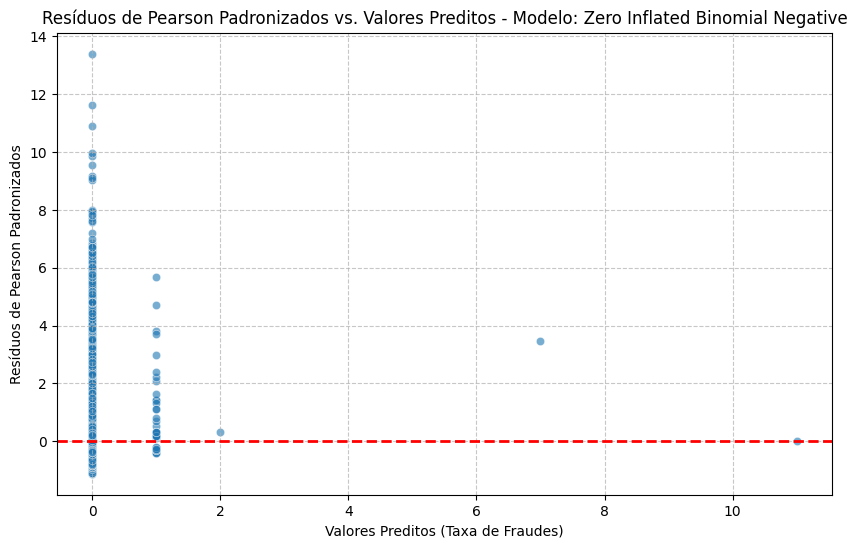

In [152]:
overdisp_plot(modelo_zinb_stepwise, 'Zero Inflated Binomial Negative')

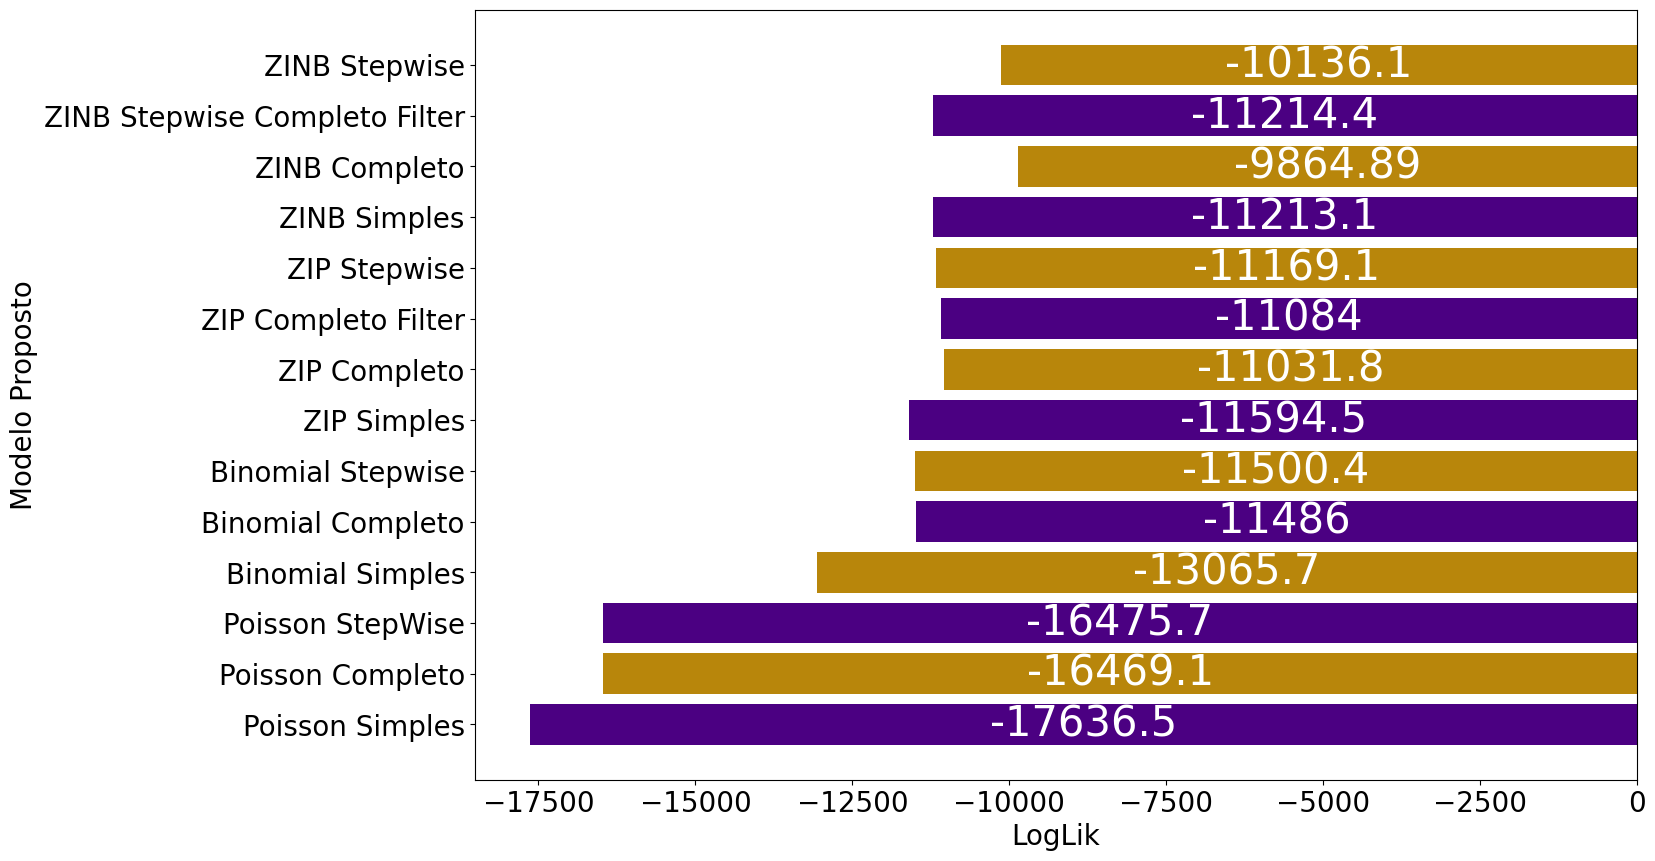

In [153]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Completo Filter',
        'ZIP Stepwise',
        'ZINB Simples',
        'ZINB Completo',
        'ZINB Stepwise Completo Filter',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_complete_filter.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb_simples.llf,
        modelo_zinb_complete.llf,
        modelo_zinb_complete_filter.llf,
        modelo_zinb_stepwise.llf
      ]
})

In [154]:
titles = [
  'Poisson Simples',
  'Poisson Completo',
  'Poisson StepWise',
  'Binomial Simples',
  'Binomial Completo',
  'Binomial Stepwise',
  'ZIP Simples',
  'ZIP Completo',
  'ZIP Completo Filter',
  'ZIP Stepwise',
  'ZIMB Simples',
  'ZIMB Completo',
  'ZIMB Completo Filter',
  'ZIMB Stepwise',
]
models = [
    modelo_poison_simple,
    modelo_poison_complete,
    modelo_poisson_stepswise,
    modelo_binomialneg_simples,
    modelo_binomialneg_completo,
    modelo_binomialneg_stepwise,
    modelo_zip_simples,
    modelo_zip_complete,
    modelo_zip_complete_filter,
    modelo_zip_stepwise,
    modelo_zinb_simples,
    modelo_zinb_complete,
    modelo_zinb_complete_filter,
    modelo_zinb_stepwise
]

In [156]:
metrics = []
for title, model in zip(titles, models):
  metric = dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic)

  if np.isnan(model.llf):
    continue

  if hasattr(model, 'prsquared'):
    metric['PseudoR2'] = model.prsquared
  else:
    metric['PseudoR2'] = model.pseudo_rsquared()

  metrics.append(metric)

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this messa

In [157]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by='AIC')

,title,LLF,BIC,AIC,PseudoR2
11,ZIMB Completo,-9864.891341,20591.078001,19923.782683,1.203366e-01
13,ZIMB Stepwise,-10136.133687,20396.578039,20300.267375,9.614961e-02
8,ZIP Completo Filter,-11083.967792,22478.712244,22237.935583,1.173434e-01
7,ZIP Completo,-11031.798816,22916.013616,22255.597631,1.214978e-01
9,ZIP Stepwise,-11169.062854,22524.591704,22380.125708,1.105670e-01
12,ZIMB Completo Filter,-11214.393221,22455.424442,22434.786442,8.974244e-11
10,ZIMB Simples,-11213.055502,22470.507671,22436.111005,1.192859e-04
5,Binomial Stepwise,-11500.416127,-53300.515592,23048.832254,3.538411e-01
4,Binomial Completo,-11485.977898,-53116.288054,23067.955796,3.564339e-01
6,ZIP Simples,-11594.463763,23224.444859,23196.927526,7.669076e-02


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


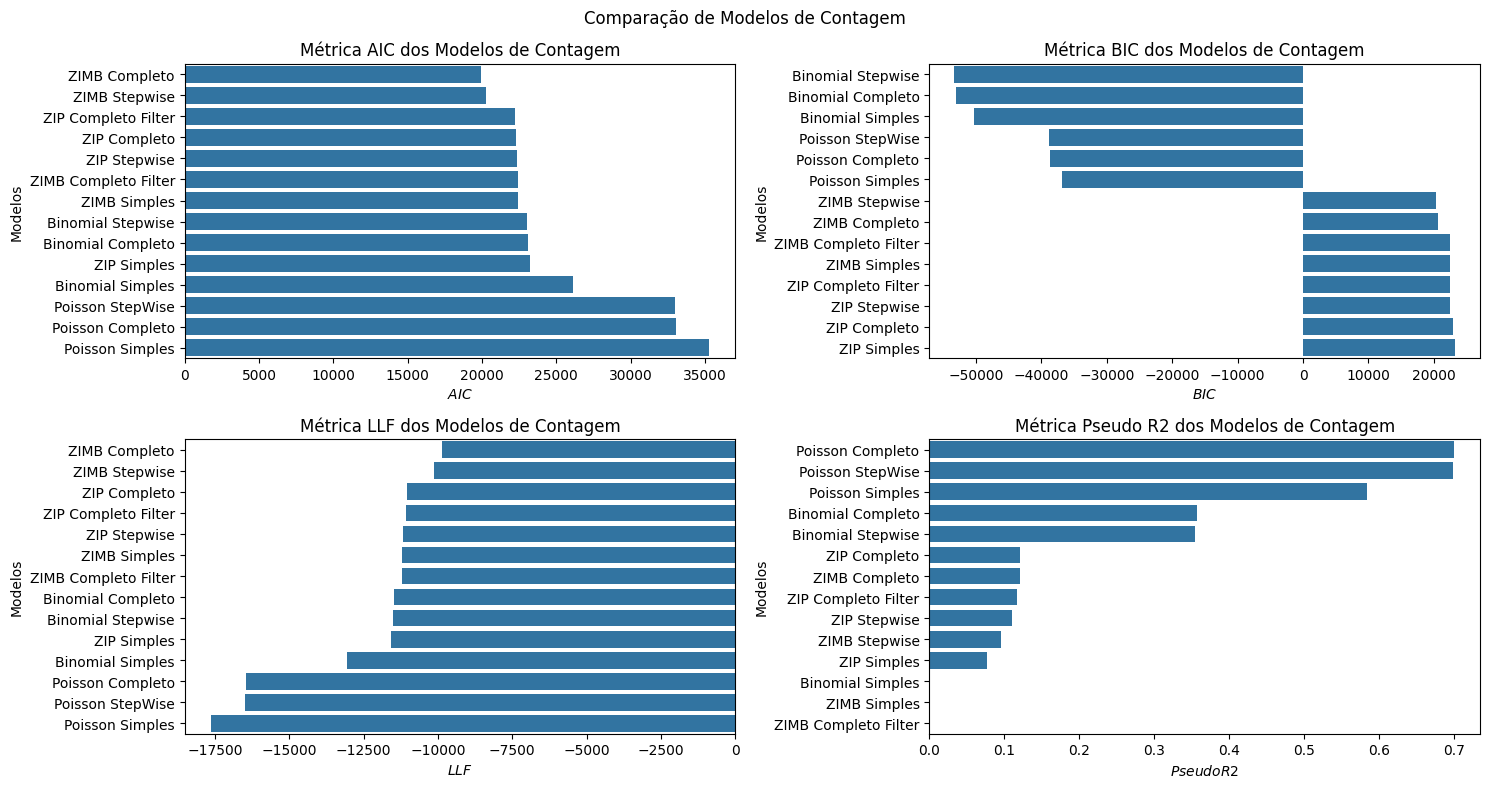

In [158]:
plt.figure(figsize=(15,8))
plt.suptitle('Comparação de Modelos de Contagem')

plt.subplot(2,2,1)
plt.title('Métrica AIC dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(by=['AIC', 'title'], ascending=True), y='title', x='AIC')
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

plt.subplot(2,2,2)
plt.title('Métrica BIC dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['BIC', 'title'], ascending=True), y='title', x='BIC')
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

plt.subplot(2,2,3)
plt.title('Métrica LLF dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['LLF', 'title'], ascending=False), y='title', x='LLF')
plt.xlabel('$LLF$')
plt.ylabel('Modelos')

plt.subplot(2,2,4)
plt.title('Métrica Pseudo R2 dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['PseudoR2', 'title'], ascending=False), y='title', x='PseudoR2')
plt.xlabel('$Pseudo R2$')
plt.ylabel('Modelos')

plt.tight_layout()
plt.show()

In [159]:
metrics_titles = []
metrics_mse = []
metrics_rmse = []

In [160]:
for title, model in zip(titles, models):

    if np.isnan(model.llf):
      continue

    metrics_titles.append(title)
    metrics_mse.append(mean_squared_error(y.loc[model.fittedvalues.index], round(model.fittedvalues)))
    metrics_rmse.append(root_mean_squared_error(y.loc[model.fittedvalues.index], round(model.fittedvalues)))

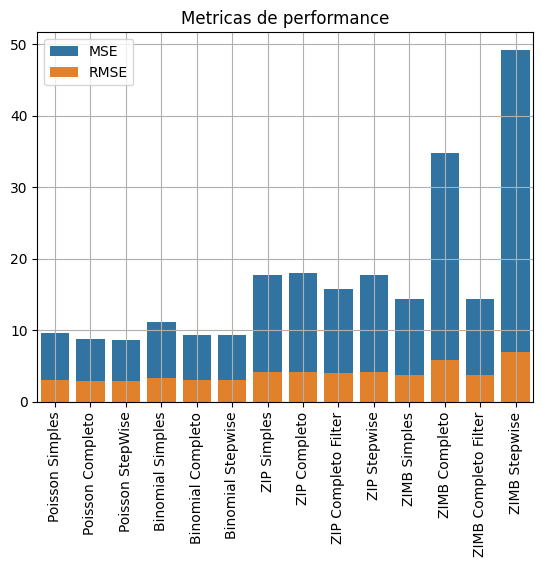

In [161]:
plt.title('Metricas de performance')
sns.barplot(x=metrics_titles, y=metrics_mse, label='MSE')
sns.barplot(x=metrics_titles, y=metrics_rmse, label='RMSE')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

In [162]:
df_predict_models = pd.concat([model.fittedvalues for model in models], axis=1)
df_predict_models.columns = titles

for column in df_predict_models.columns:
  df_predict_models[column] = df_predict_models[column].apply(lambda x: 0 if np.isnan(x) or int(round(x))< 0 else int(round(x)))

df_predict_models['Target'] = y
df_predict_models.head()

,Poisson Simples,Poisson Completo,Poisson StepWise,Binomial Simples,Binomial Completo,Binomial Stepwise,ZIP Simples,ZIP Completo,ZIP Completo Filter,ZIP Stepwise,ZIMB Simples,ZIMB Completo,ZIMB Completo Filter,ZIMB Stepwise,Target
0,1,1,1,2,1,1,2,1,0,0,0,0,0,0,0
1,1,2,2,2,2,2,2,0,2,0,0,2,0,0,1
2,3,2,2,2,3,3,0,0,0,1,0,0,0,0,0
3,1,0,0,2,0,0,2,2,3,0,0,2,0,0,0
4,1,1,1,2,1,2,2,1,0,4,0,1,0,0,0


In [163]:
df_resume = df_predict_models['Target'].value_counts().reset_index()
df_resume.columns = ['Target', 'Quantidade']
df_resume = df_resume.sort_values(by='Target').reset_index(drop=True)
df_resume.head()

,Target,Quantidade
0,0,4556
1,1,549
2,2,381
3,3,289
4,4,259


In [164]:
resumes = [df_resume]
for column in titles:
  df_resume = df_predict_models.assign(ok=lambda x: x['Target'] == x[column]).groupby('Target').agg({'ok':'sum'}).reset_index()
  df_resume.columns = ['Target', column]
  df_resume.drop(columns='Target', inplace=True)
  resumes.append(df_resume)
df_resume = pd.concat(resumes, axis=1)

In [165]:
df_resume

,Target,Quantidade,Poisson Simples,Poisson Completo,Poisson StepWise,Binomial Simples,Binomial Completo,Binomial Stepwise,ZIP Simples,ZIP Completo,ZIP Completo Filter,ZIP Stepwise,ZIMB Simples,ZIMB Completo,ZIMB Completo Filter,ZIMB Stepwise
0,0,4556,0,679,685,0,955,926,815,826,2060,2160,4554,1369,4556,4513
1,1,549,205,179,178,0,173,173,0,91,104,95,1,69,0,11
2,2,381,0,73,75,381,65,72,134,64,58,75,0,31,0,0
3,3,289,195,55,61,0,48,47,0,3,26,25,0,3,0,0
4,4,259,0,46,42,0,34,34,0,0,6,12,0,0,0,0
5,5,223,0,26,28,0,27,25,0,0,3,1,0,0,0,0
6,6,193,0,9,12,0,12,9,0,0,1,0,0,0,0,0
7,7,173,0,6,7,0,4,4,0,0,1,0,0,0,0,0
8,8,116,0,6,6,0,5,3,0,0,0,0,0,0,0,0
9,9,97,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [166]:
df_resume_percent = df_resume.copy()
for column in titles:
  df_resume_percent[column] = round(df_resume_percent[column] / df_resume_percent['Quantidade'], 2)
df_resume_percent

,Target,Quantidade,Poisson Simples,Poisson Completo,Poisson StepWise,Binomial Simples,Binomial Completo,Binomial Stepwise,ZIP Simples,ZIP Completo,ZIP Completo Filter,ZIP Stepwise,ZIMB Simples,ZIMB Completo,ZIMB Completo Filter,ZIMB Stepwise
0,0,4556,0.00,0.15,0.15,0.0,0.21,0.20,0.18,0.18,0.45,0.47,1.0,0.30,1.0,0.99
1,1,549,0.37,0.33,0.32,0.0,0.32,0.32,0.00,0.17,0.19,0.17,0.0,0.13,0.0,0.02
2,2,381,0.00,0.19,0.20,1.0,0.17,0.19,0.35,0.17,0.15,0.20,0.0,0.08,0.0,0.00
3,3,289,0.67,0.19,0.21,0.0,0.17,0.16,0.00,0.01,0.09,0.09,0.0,0.01,0.0,0.00
4,4,259,0.00,0.18,0.16,0.0,0.13,0.13,0.00,0.00,0.02,0.05,0.0,0.00,0.0,0.00
5,5,223,0.00,0.12,0.13,0.0,0.12,0.11,0.00,0.00,0.01,0.00,0.0,0.00,0.0,0.00
6,6,193,0.00,0.05,0.06,0.0,0.06,0.05,0.00,0.00,0.01,0.00,0.0,0.00,0.0,0.00
7,7,173,0.00,0.03,0.04,0.0,0.02,0.02,0.00,0.00,0.01,0.00,0.0,0.00,0.0,0.00
8,8,116,0.00,0.05,0.05,0.0,0.04,0.03,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
9,9,97,0.00,0.00,0.00,0.0,0.00,0.01,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00


In [170]:
df_resume_percent[titles].apply(lambda x: (len([1 for xi in x if xi > 0])/len(x)) * x.sum(), axis=0).sort_values(ascending=False)

,0
Poisson StepWise,0.492593
Poisson Completo,0.481481
Binomial Completo,0.462963
Binomial Stepwise,0.451852
ZIP Completo Filter,0.275556
ZIP Stepwise,0.181481
ZIP Completo,0.078519
Poisson Simples,0.077037
ZIMB Completo,0.077037
ZIMB Stepwise,0.074815
